# Imports and setup

Want to rerun with smaller grid size for this stream since it is less long than GD-1. Is this something we have to change for each stream or is there a value that would be small enough for Pal 5 and still be ok for GD-1?

In [2]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)


from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [3]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [4]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [7]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-M92.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

stream='M92'
phi1_lim = (np.min(cat['phi1']), np.max(cat['phi1']))
phi1_lim = [-10,10]

cat = cat[(cat['phi1'] < phi1_lim[1]) & (cat['phi1'] > phi1_lim[0])] # clunky to hard code this

In [8]:
import importlib
importlib.reload(sys.modules['cats.pawprint.pawprint'])
importlib.reload(sys.modules['cats.CMD'])
importlib.reload(sys.modules['cats.proper_motions'])
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg,
                                      phi1_lim=phi1_lim)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track


In [9]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

-0.17116191762005428
Fitting for peak pm location
Pre-fitting mean PM values: -3.709, -3.152
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-3.8538123991126163, -3.168753042538279, 0.2724190858208264, 0.29705293404488536] 

Producing the polygon and mask


In [10]:
##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

In [11]:
Base.setup(p, cat)
print(Base.coord_bounds)

{'phi1': (-9.999980987480058, 9.999999939931278), 'phi2': (-9.999999904768673, 9.999995208117767), 'pm1': (-7.597806965459313, -1.2885415343297382), 'pm2': (-7.145848420806374, -0.12768208453979923)}


In [12]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [13]:
len(bkg_data['phi1'])

88283

In [14]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

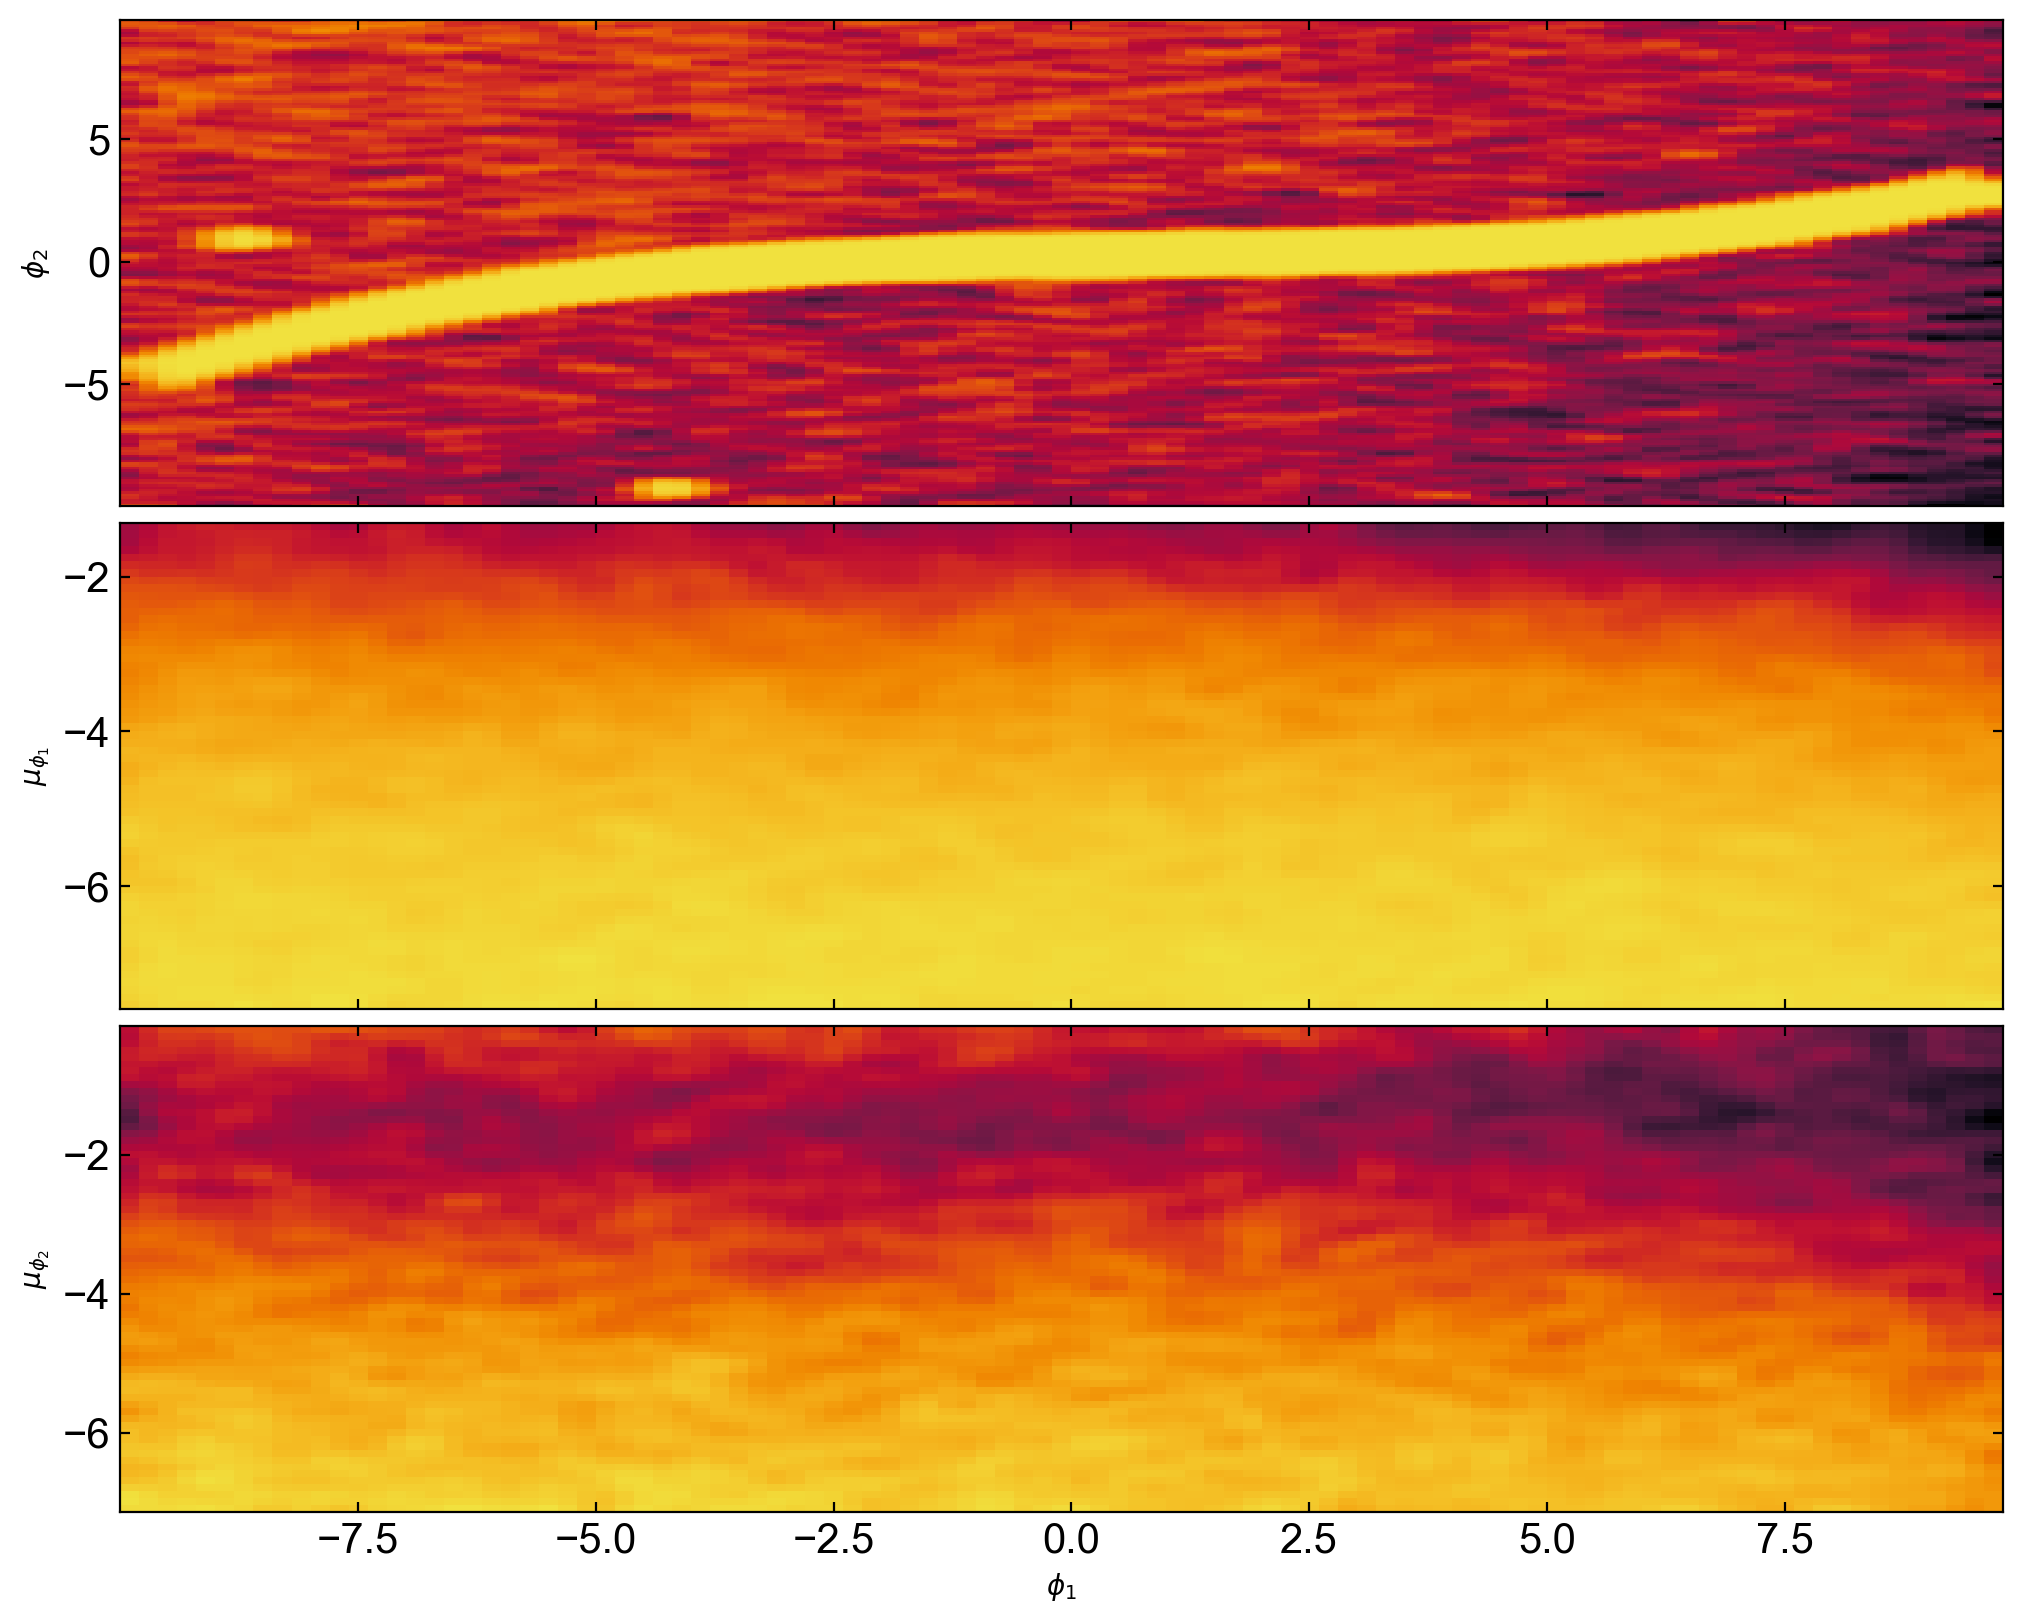

In [49]:
plot_data_projections(data=bkg_data, grids=Base.default_grids,
                      smooth=1);

# Background

In [16]:
BackgroundModel.bkg_update(pawprint=p, data=cat, knot_sep=5)

In [17]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    "phi1": {'zs': np.zeros(BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {
        # "w": np.full_like(BackgroundModel.phi2_knots, 0.5),
        # 'mean':np.full_like(BackgroundModel.phi2_knots, 10),
        # 'ln_std': np.full_like(BackgroundModel.phi2_knots, 2),
        # 'mean2':np.full_like(BackgroundModel.phi2_knots, -10),
        # 'ln_std2': np.full_like(BackgroundModel.phi2_knots, 2),
    },
    "pm1": {
        "w": np.full_like(BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm1_knots, 3),
        "ln_std1": np.full_like(BackgroundModel.pm1_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm1_knots, 5),
        "ln_std2": np.full_like(BackgroundModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm2_knots, 0),
        "ln_std1": np.full_like(BackgroundModel.pm2_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm2_knots, 1),
        "ln_std2": np.full_like(BackgroundModel.pm2_knots, 2)
    },
}

background_init = BackgroundModel(bkg_init_p)

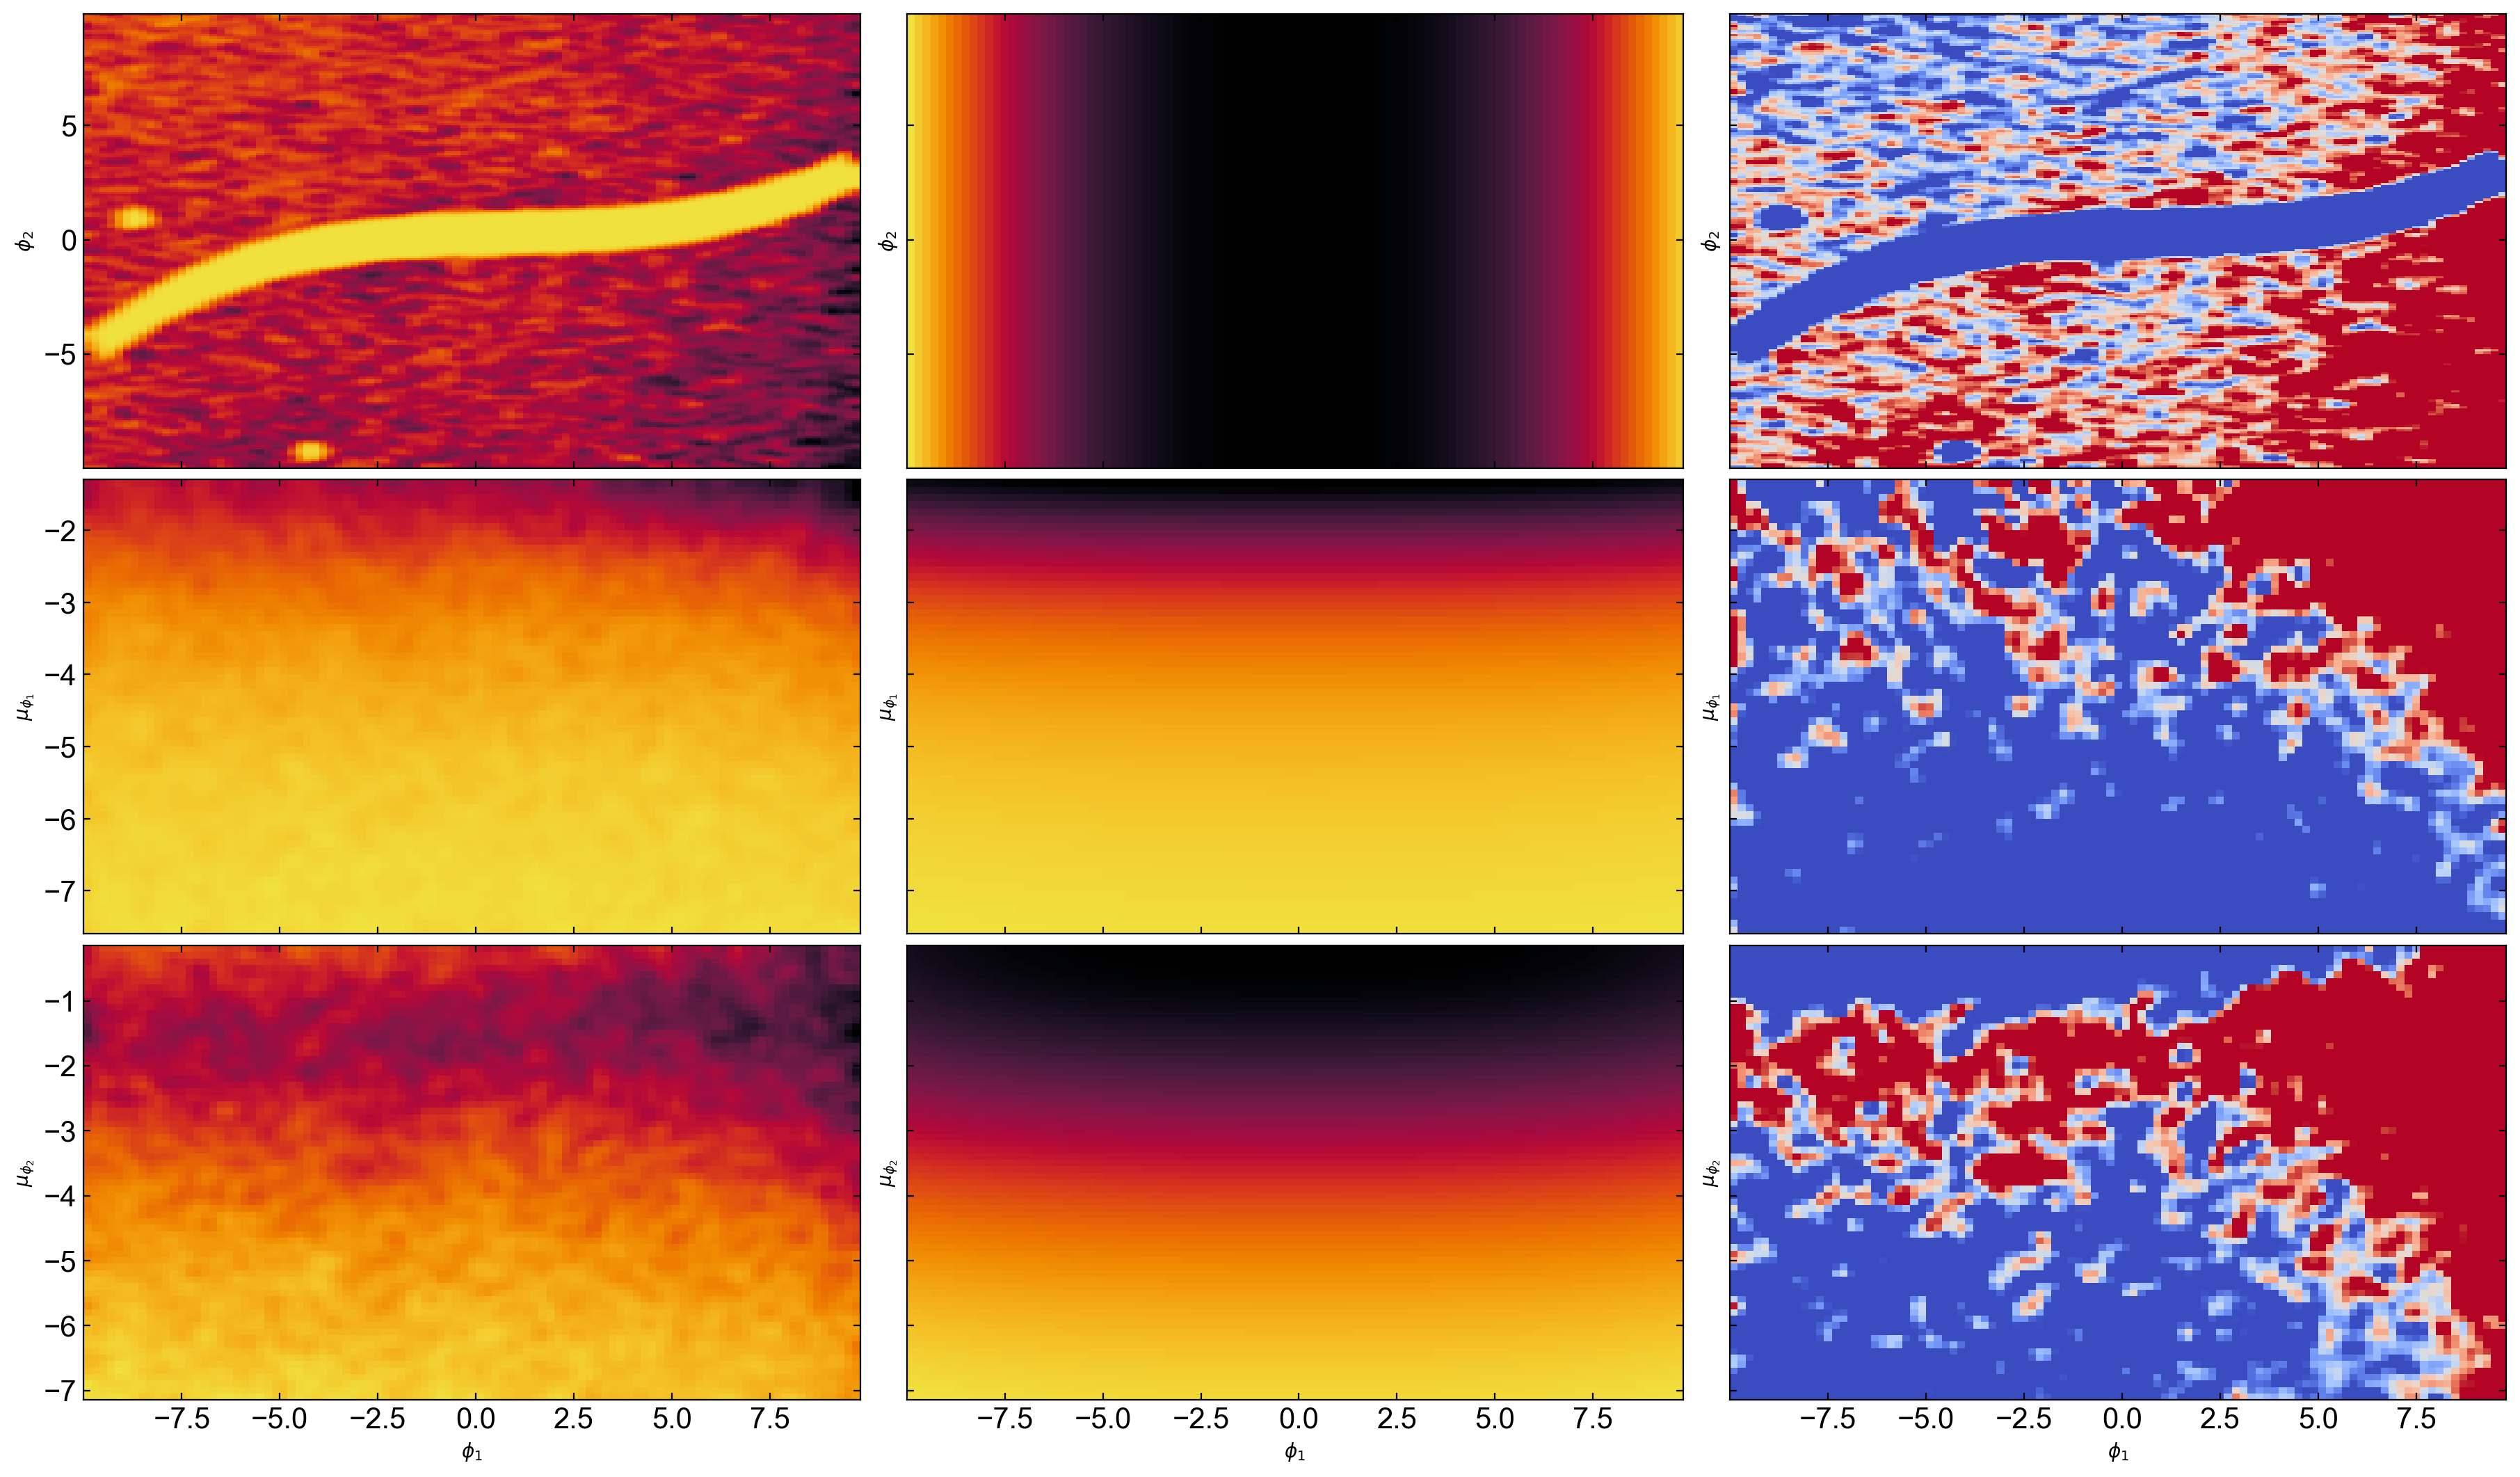

In [18]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=background_init.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

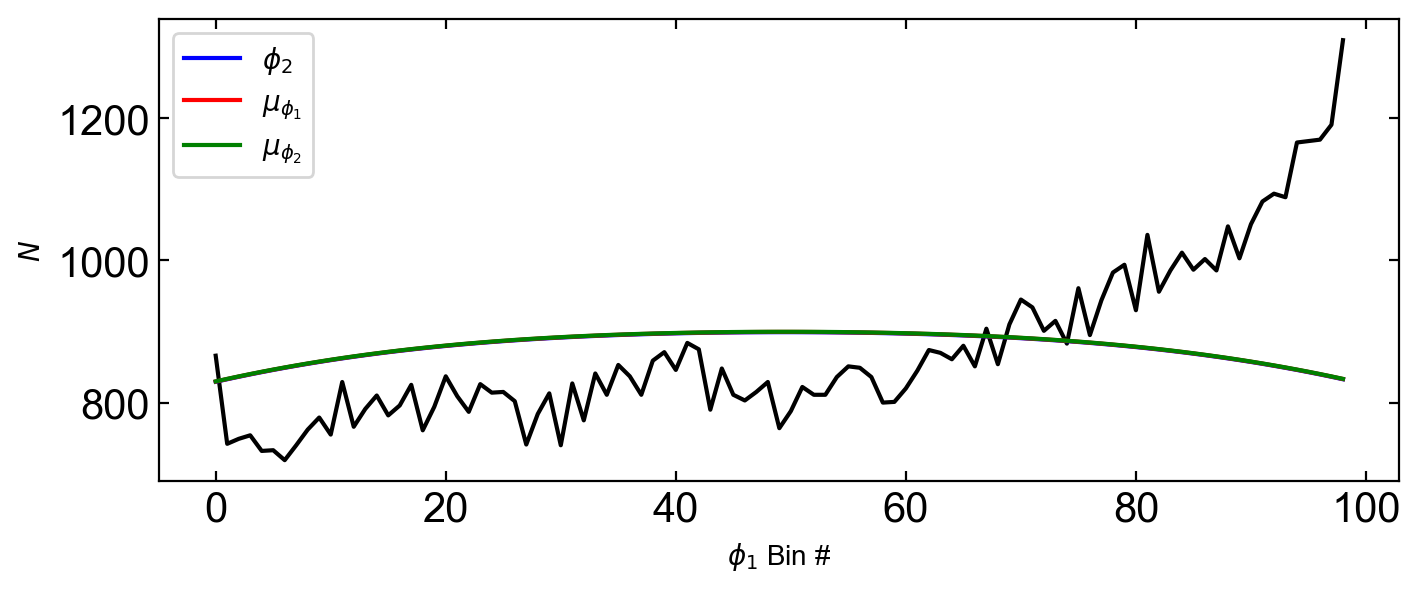

In [19]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [240]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [20]:
bkg_opt_pars, bkg_info = BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = BackgroundModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(-1.10608525, dtype=float64, weak_type=True), success=True, status=0, iter_num=501, hess_inv=LbfgsInvHessProduct(sk=[[ 2.51602412e-05 -4.36703661e-04 -8.96003598e-05 -7.73287471e-04
  -4.94311471e-04 -3.07082785e-04 -1.27860872e-04 -2.27993900e-04
  -2.18423757e-04  2.05222224e-04  1.80452292e-04  3.04785027e-05
   2.08236157e-04  2.72781145e-04  4.37822343e-04  1.66680874e-04
   5.50730115e-04 -9.18466068e-04 -1.06984103e-03  4.48458583e-04
   3.98286157e-04  7.24082908e-05 -4.11076528e-05 -1.52447655e-04
   1.88466481e-04  3.81202875e-05  1.48714822e-04  7.72037630e-05
   3.53821219e-04  6.58564660e-04  4.28822293e-04  4.18983613e-04
   1.78967604e-04 -4.84452232e-04  8.01132304e-05  1.11066108e-03
  -1.20843501e-03 -4.79994143e-05 -1.90568820e-04  3.60970920e-04
   1.15907275e-04 -7.80149864e-04  6.03854502e-05  5.12952020e-05
   4.91612387e-04  1.53643186e-03  3.65330037e-04 -5.20601925e-04
  -4.40406387e-04 -4.86078081e-05 -7.52542683e-04 -4.89179859

In [21]:
bkg_opt_pars

{'ln_N': Array(11.38830565, dtype=float64),
 'phi1': {'zs': Array([-3.27728472,  1.51346189, -2.90465873, -4.62022679, -5.88741051,
         -7.50220487], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([0.88402118, 0.79288922, 0.99986642, 0.92091559, 0.76070762],      dtype=float64),
  'ln_std2': Array([1.60197478, 1.50298641, 1.4248797 , 1.42041446, 1.42194457],      dtype=float64),
  'mean1': Array([2.52924273, 1.16673093, 3.89117054, 4.02148282, 3.12027994],      dtype=float64),
  'mean2': Array([4.94142   , 4.93347183, 5.37968448, 5.02678854, 5.20345926],      dtype=float64),
  'w': Array([0.41703682, 0.39237524, 0.32373084, 0.37708562, 0.25872144],      dtype=float64)},
 'pm2': {'ln_std1': Array([-0.27889311,  0.29918785,  0.351539  ,  0.33694912,  0.54624689],      dtype=float64),
  'ln_std2': Array([1.14652945, 1.05142217, 0.76238268, 1.07121466, 1.54684196],      dtype=float64),
  'mean1': Array([-1.65411422, -1.56979566, -1.24808685, -1.12127799, -1.67207919],      dt

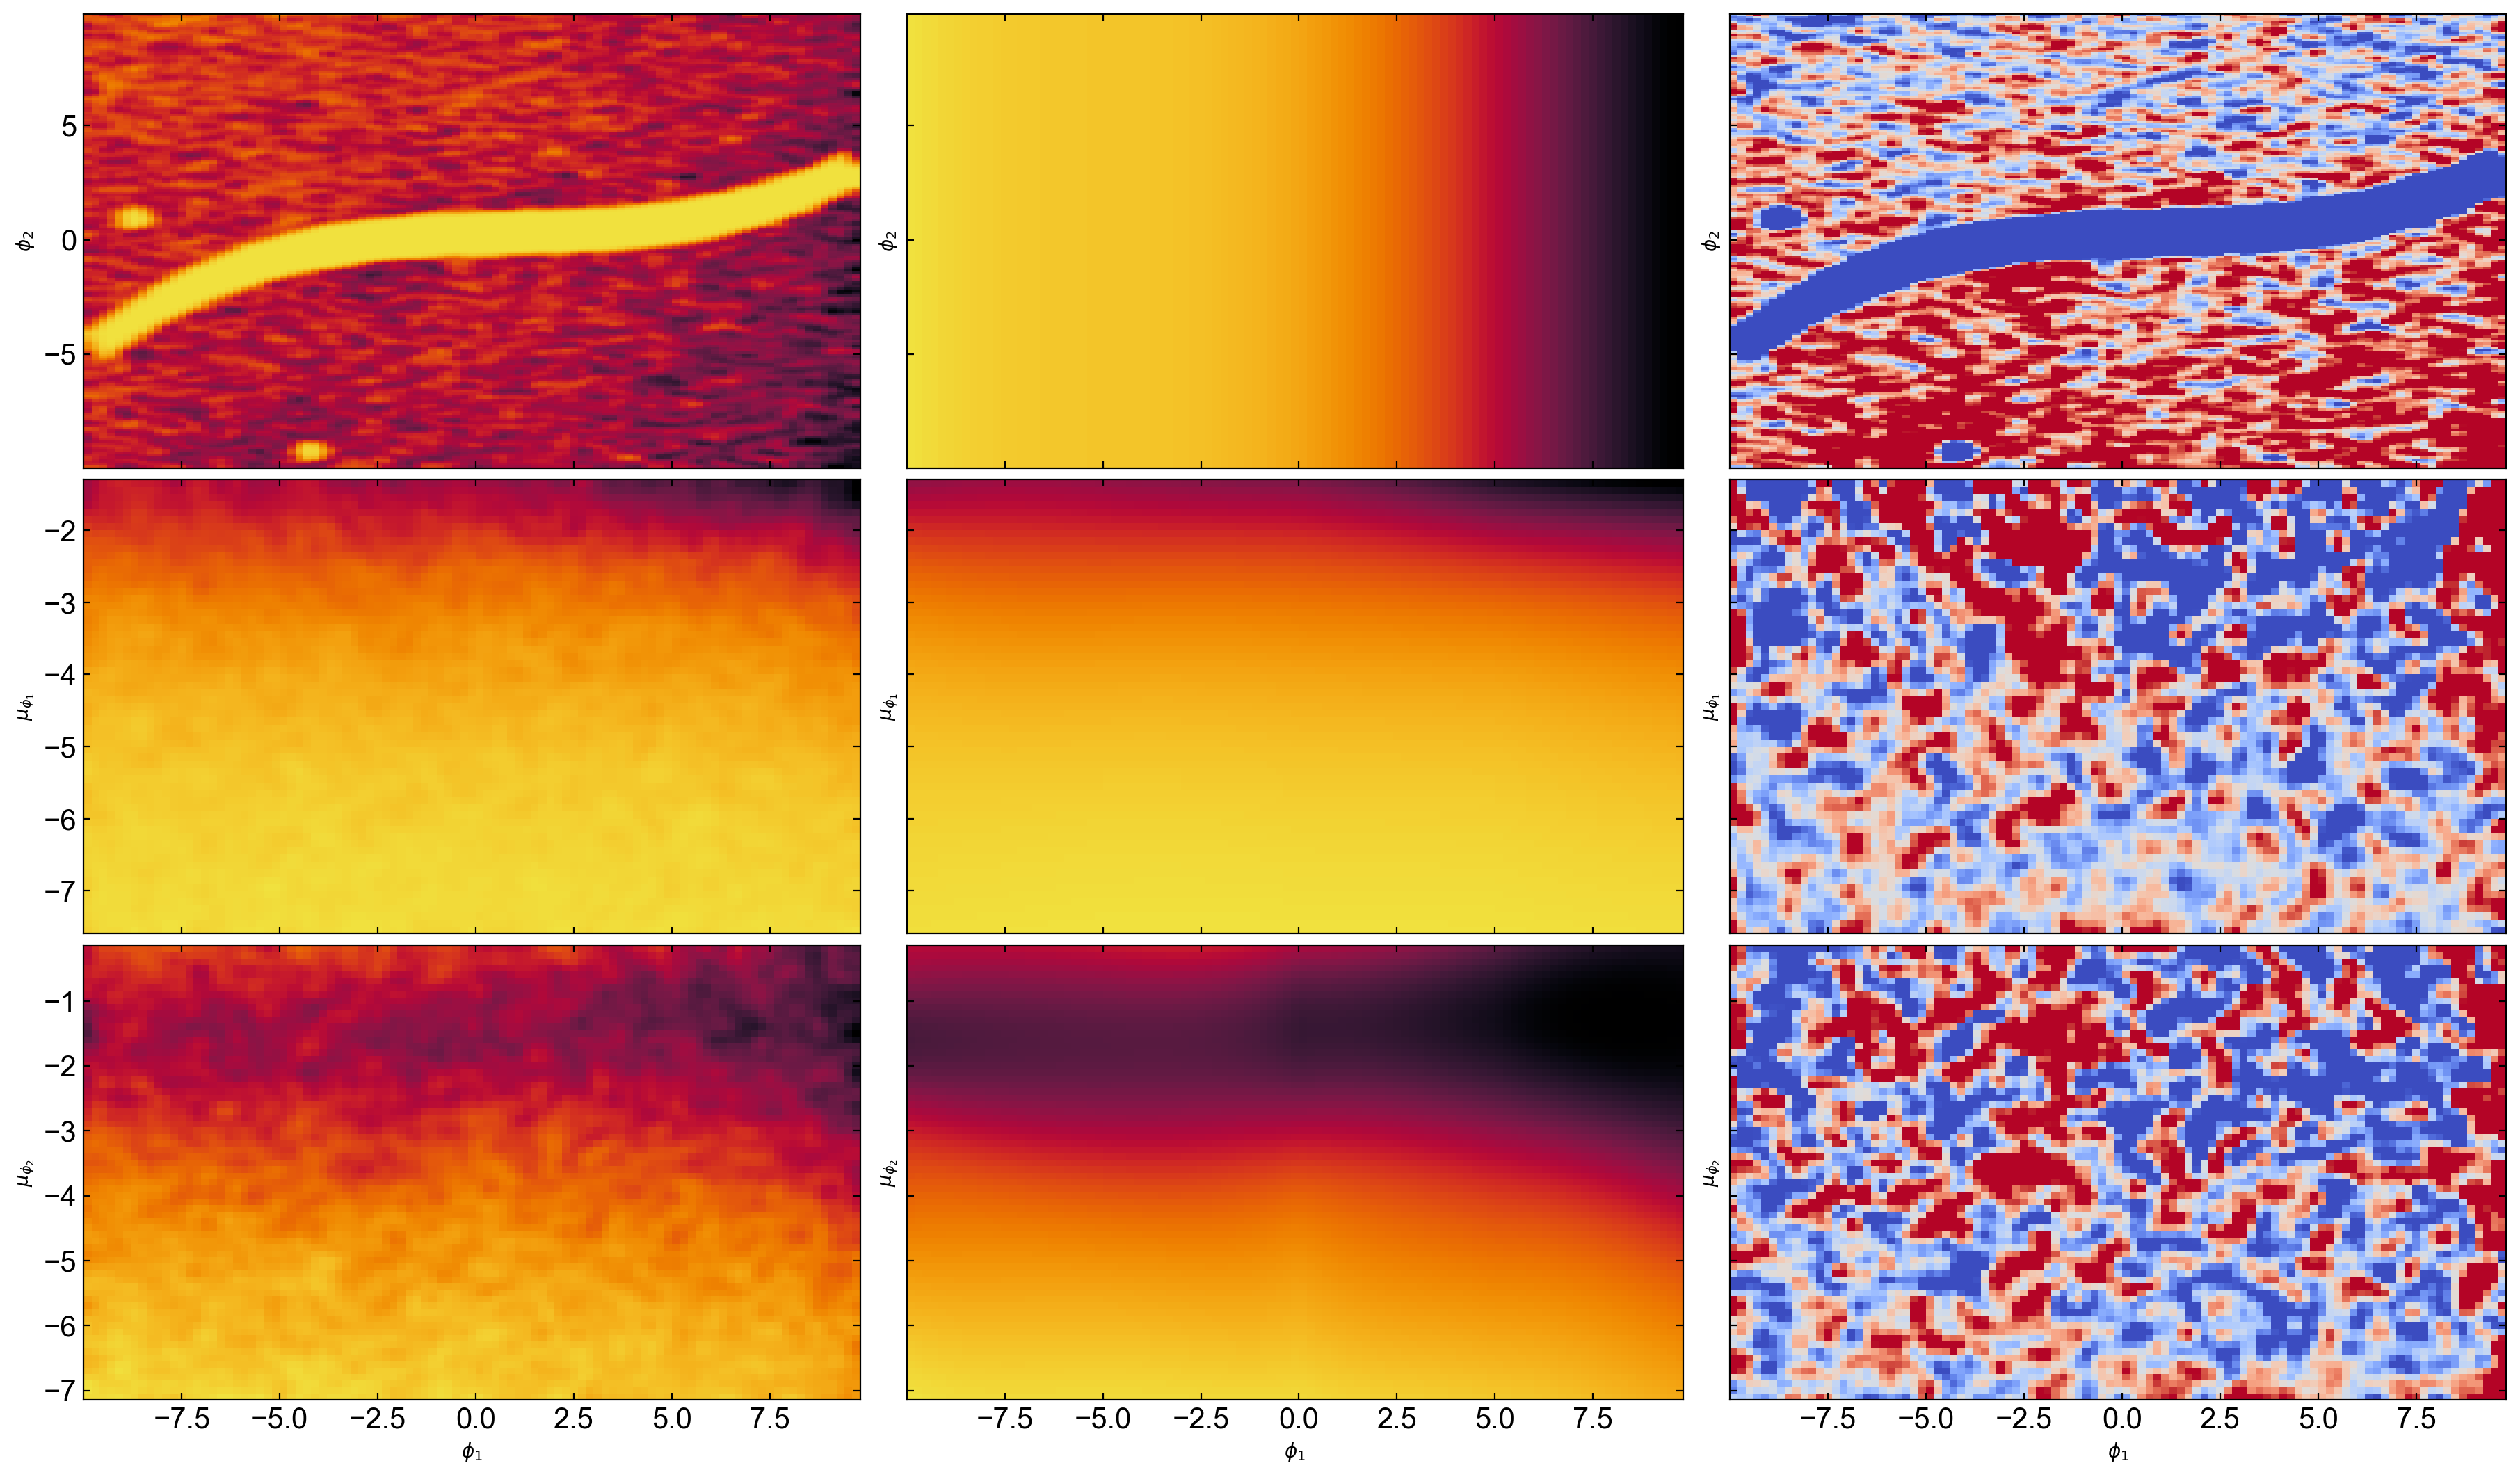

In [22]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")
fig.savefig('pal5_background.png')

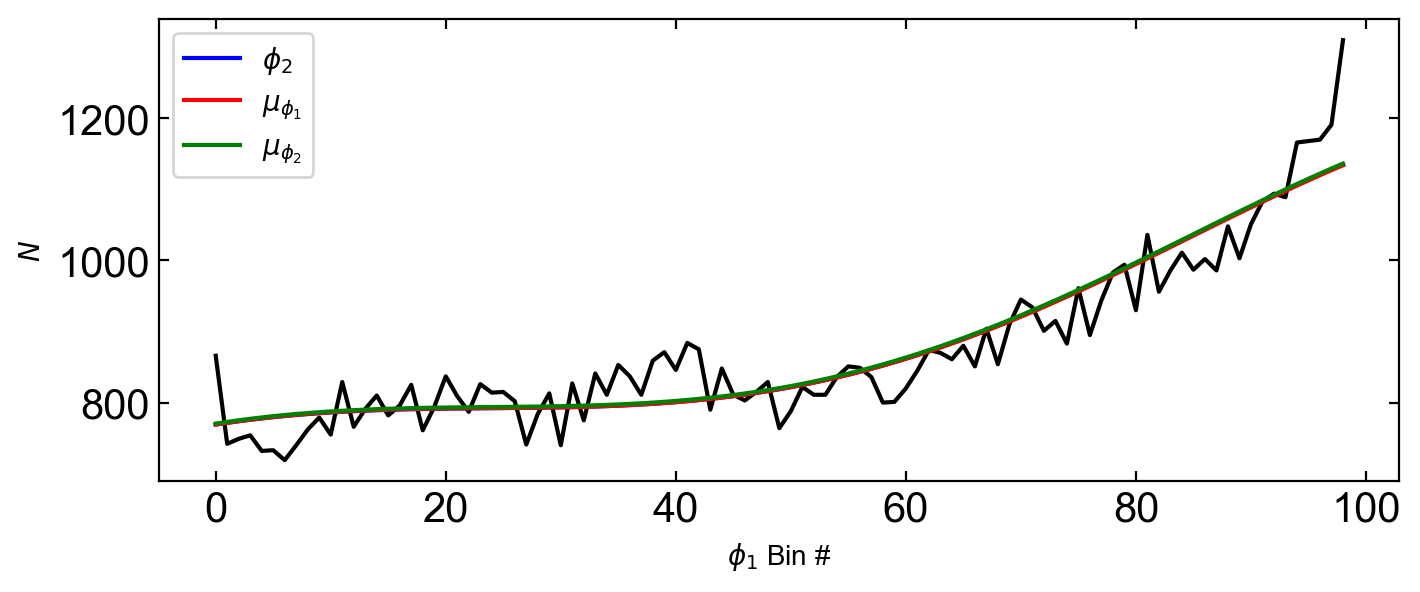

In [23]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)

grids, ln_ns = background_opt.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

# Stream

In [24]:
StreamDensModel.stream_dens_update(p, cat, knot_sep=5)

In [25]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 21))
_phi2_interp = IUS(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic, ext=0, k=1
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm1_interp = IUS(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=0, k=1
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm2_interp = IUS(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=0, k=1
)

In [26]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

In [35]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, 0)
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -1)
    }
}

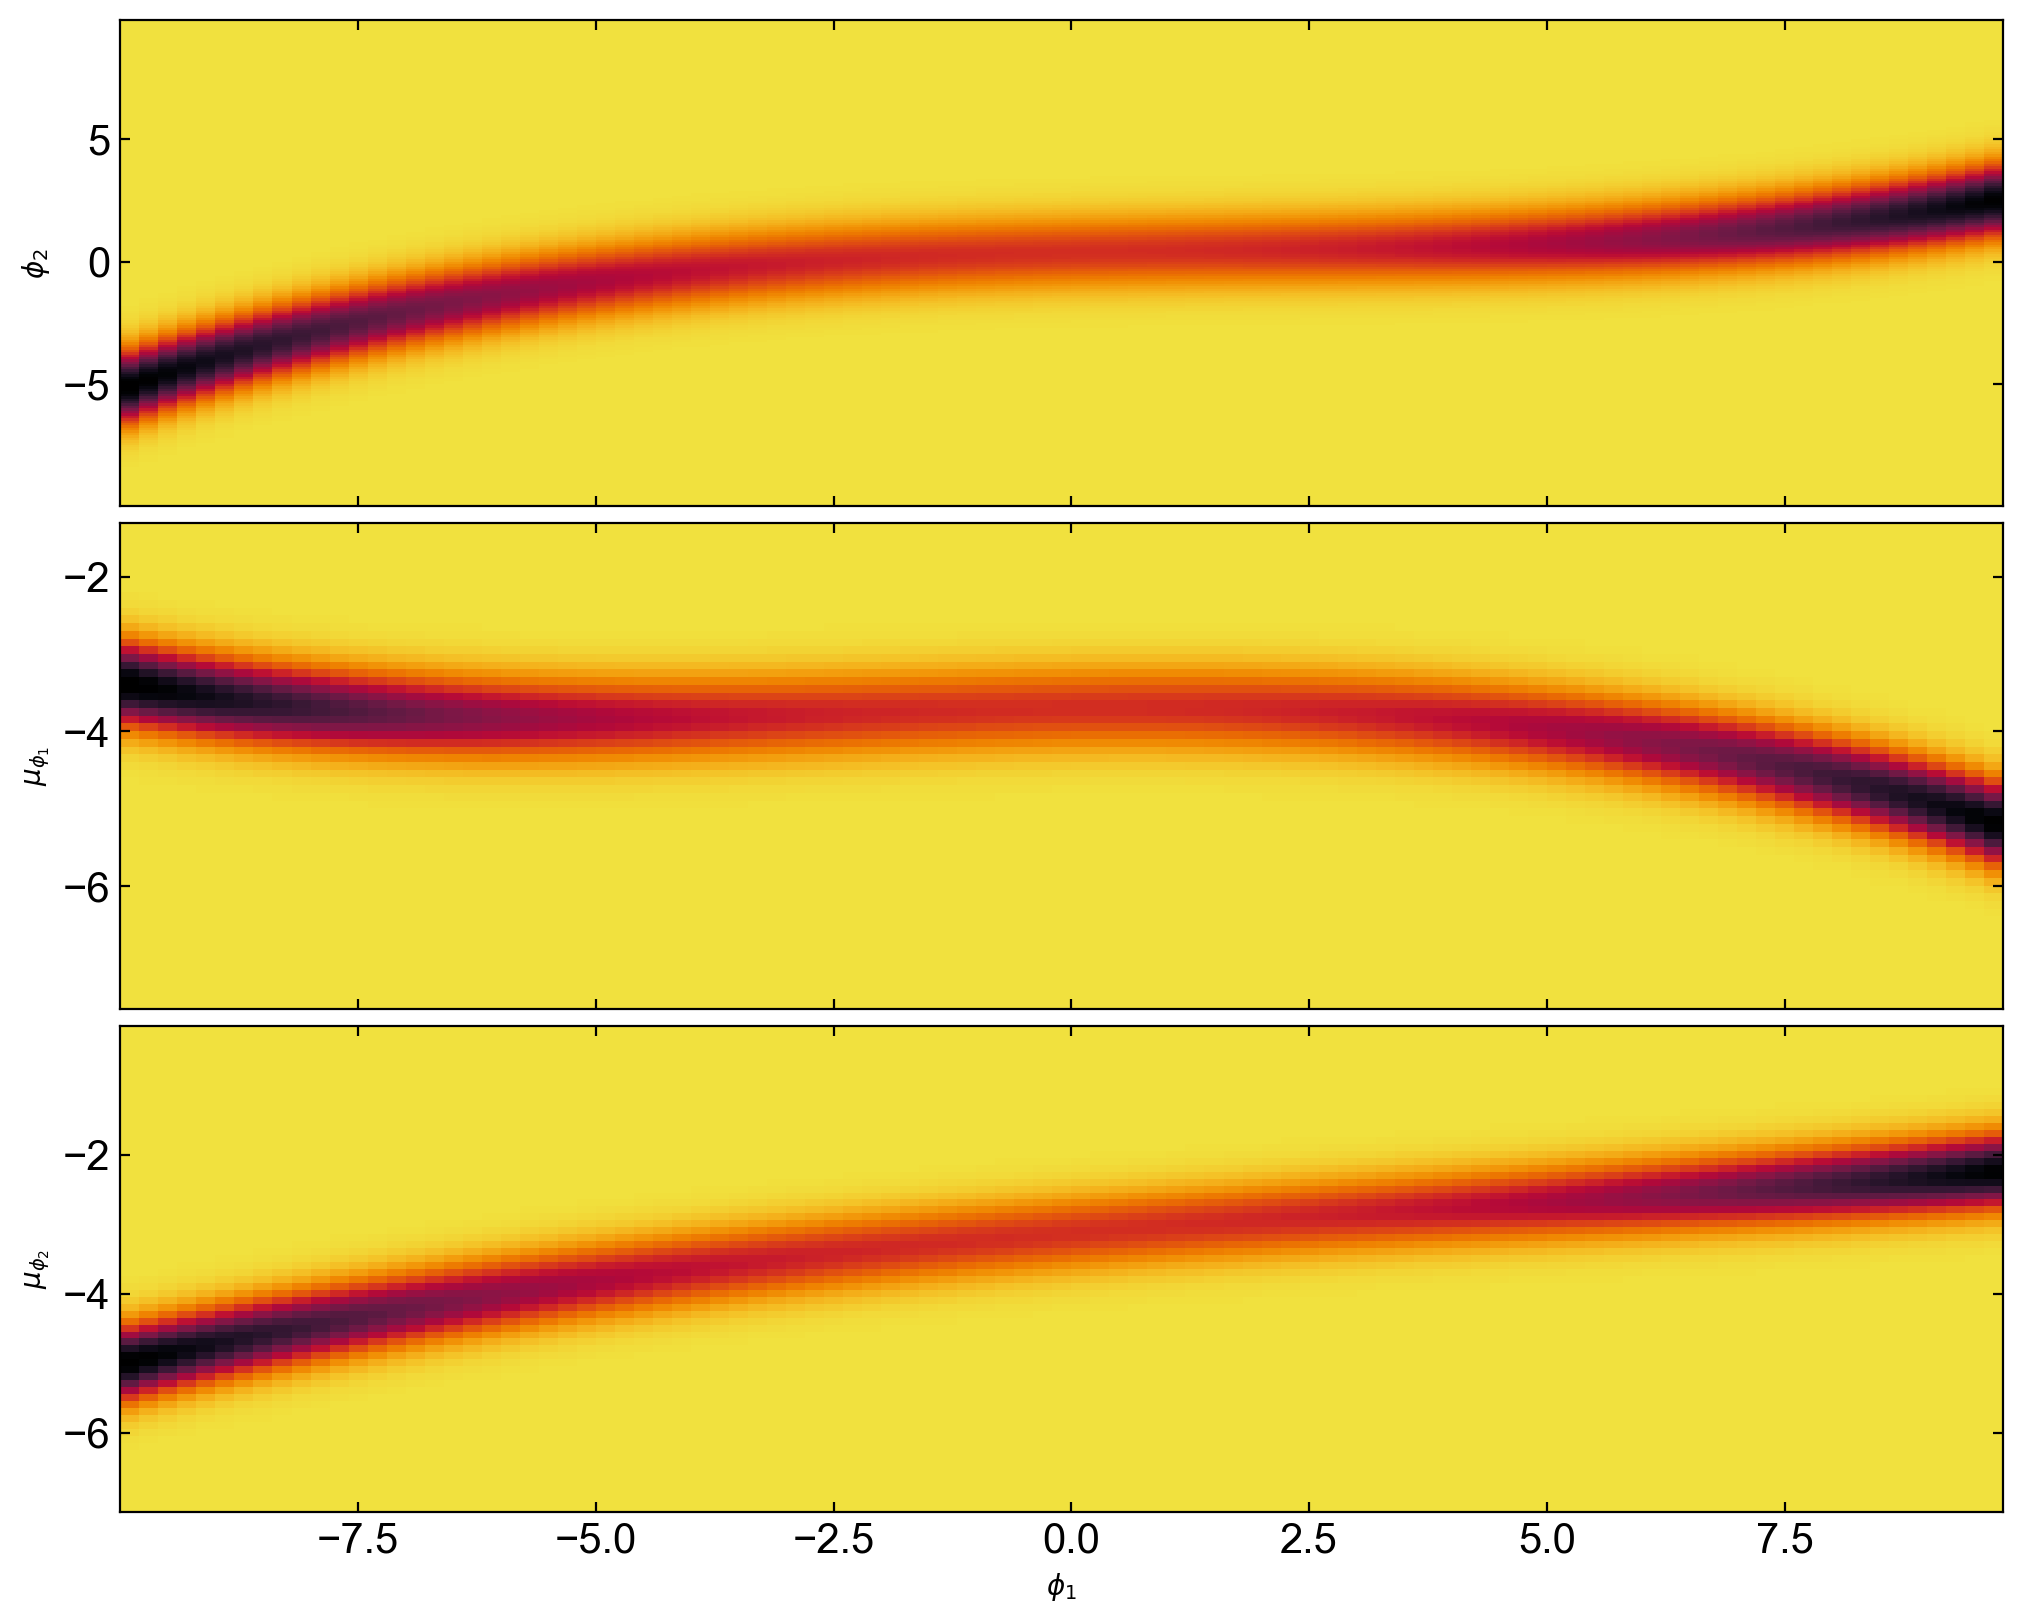

In [36]:
stream_init = StreamDensModel(stream_init_p)
_ = stream_init.plot_model_projections()

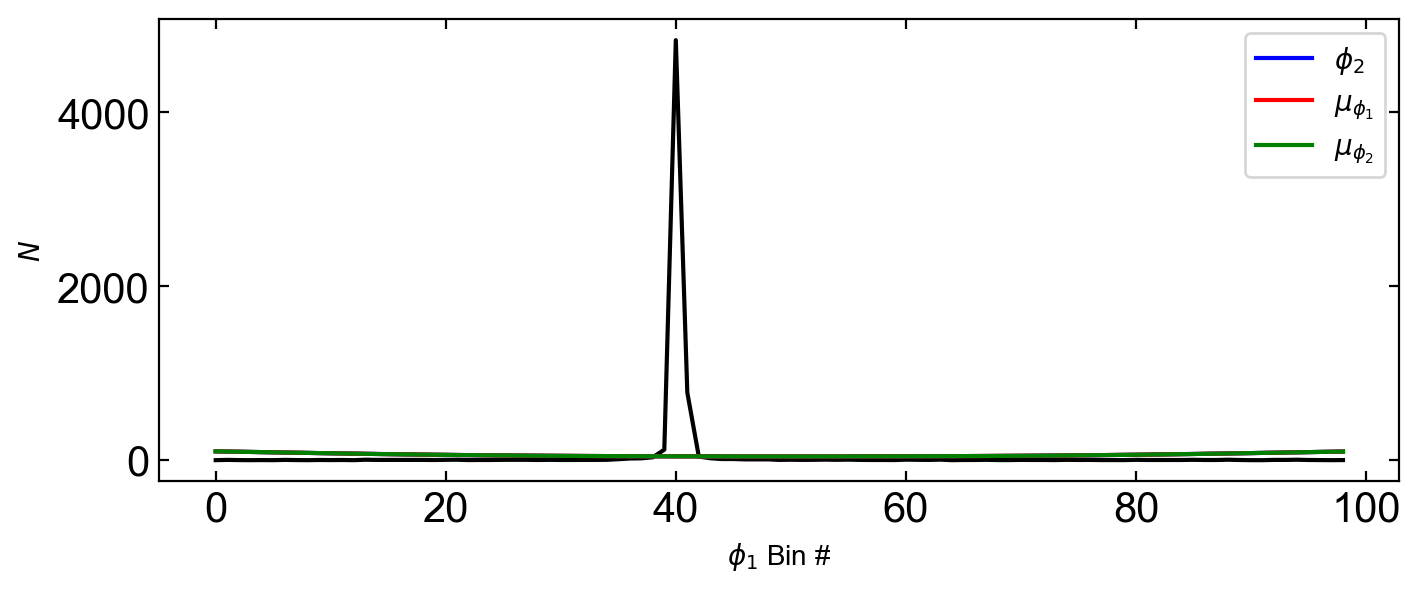

In [37]:
H_data1, *_ = np.histogram2d(
    stream_data["phi1"],
    stream_data["phi2"],
    bins=(stream_init.default_grids["phi1"], stream_init.default_grids['phi2'])
)

grids, ln_ns = stream_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [38]:
stream_init_p

{'ln_N': 8.722580021141189,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-5.24016622, -0.81414197,  0.3717305 ,  0.71982071,  2.69959071]),
  'ln_std': array([0., 0., 0., 0., 0.])},
 'pm1': {'mean': array([-3.36999666, -3.83568809, -3.70443975, -3.95975724, -5.30168694]),
  'ln_std': array([-1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-5.02225236, -3.8206049 , -3.13436217, -2.69513838, -2.2146856 ]),
  'ln_std': array([-1., -1., -1., -1., -1.])}}

In [39]:
stream_opt_pars, info = StreamDensModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = StreamDensModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-5.89251481, dtype=float64, weak_type=True), success=True, status=0, iter_num=434, hess_inv=LbfgsInvHessProduct(sk=[[-1.36068043e-05  0.00000000e+00  0.00000000e+00 -1.51202129e-03
   0.00000000e+00  0.00000000e+00  3.38108184e-05  3.49317531e-06
  -6.76620624e-04 -7.66583206e-05 -7.22511592e-05  0.00000000e+00
   1.18363676e-04 -1.63088614e-03 -2.59809694e-04  1.34239936e-04
   6.62517424e-04  0.00000000e+00 -8.05356099e-06 -1.75678308e-04
   1.08241615e-04  2.34725916e-04 -2.30713213e-05 -1.18143569e-04
   8.01226611e-05 -6.68964960e-05 -1.68259717e-04  2.56700195e-05
   7.79799393e-05  1.39084149e-04 -1.16551581e-04  2.19960448e-04
   3.01180067e-05  4.51903380e-05  1.66034828e-04 -8.99033467e-05
  -1.30321438e-04  1.62592261e-05]
 [-2.59751945e-05  0.00000000e+00  0.00000000e+00 -1.11606315e-03
   0.00000000e+00  0.00000000e+00  2.61138027e-05  2.70520922e-06
  -5.63343787e-04 -7.10481596e-05 -5.54246991e-05  0.00000000e+00
   1.42146893e-05 -1.14882

Text(0, 0.5, '$\\phi_2$')

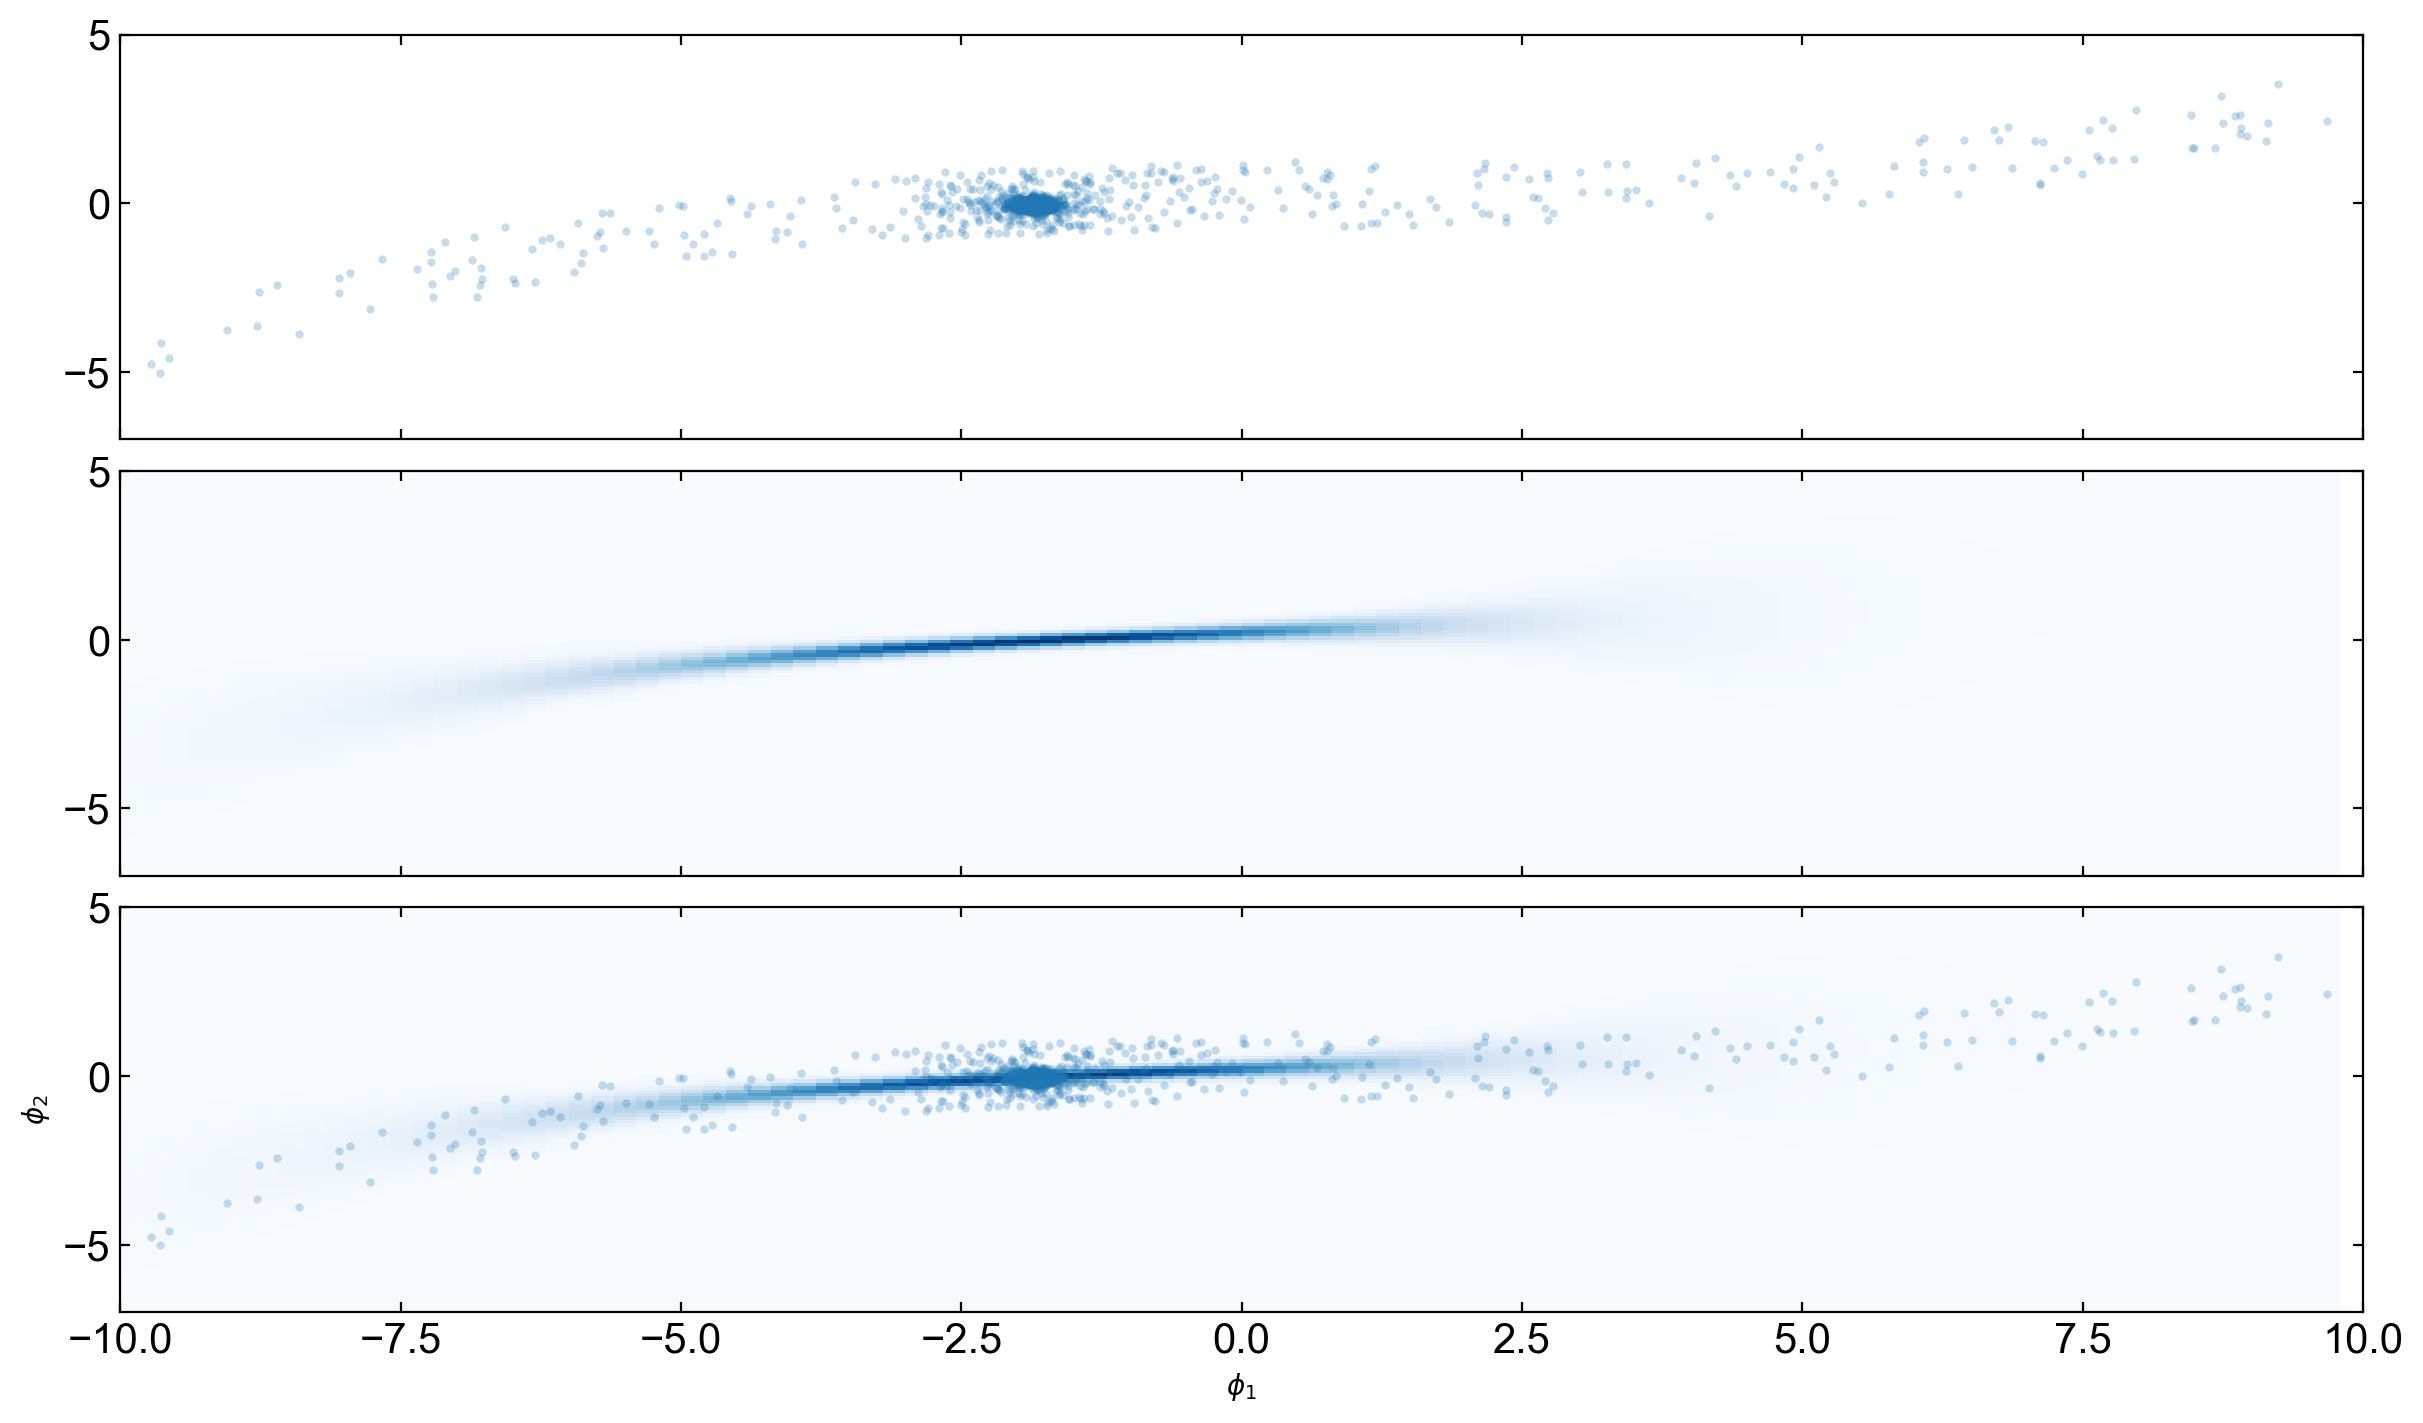

In [40]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-10, 10)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

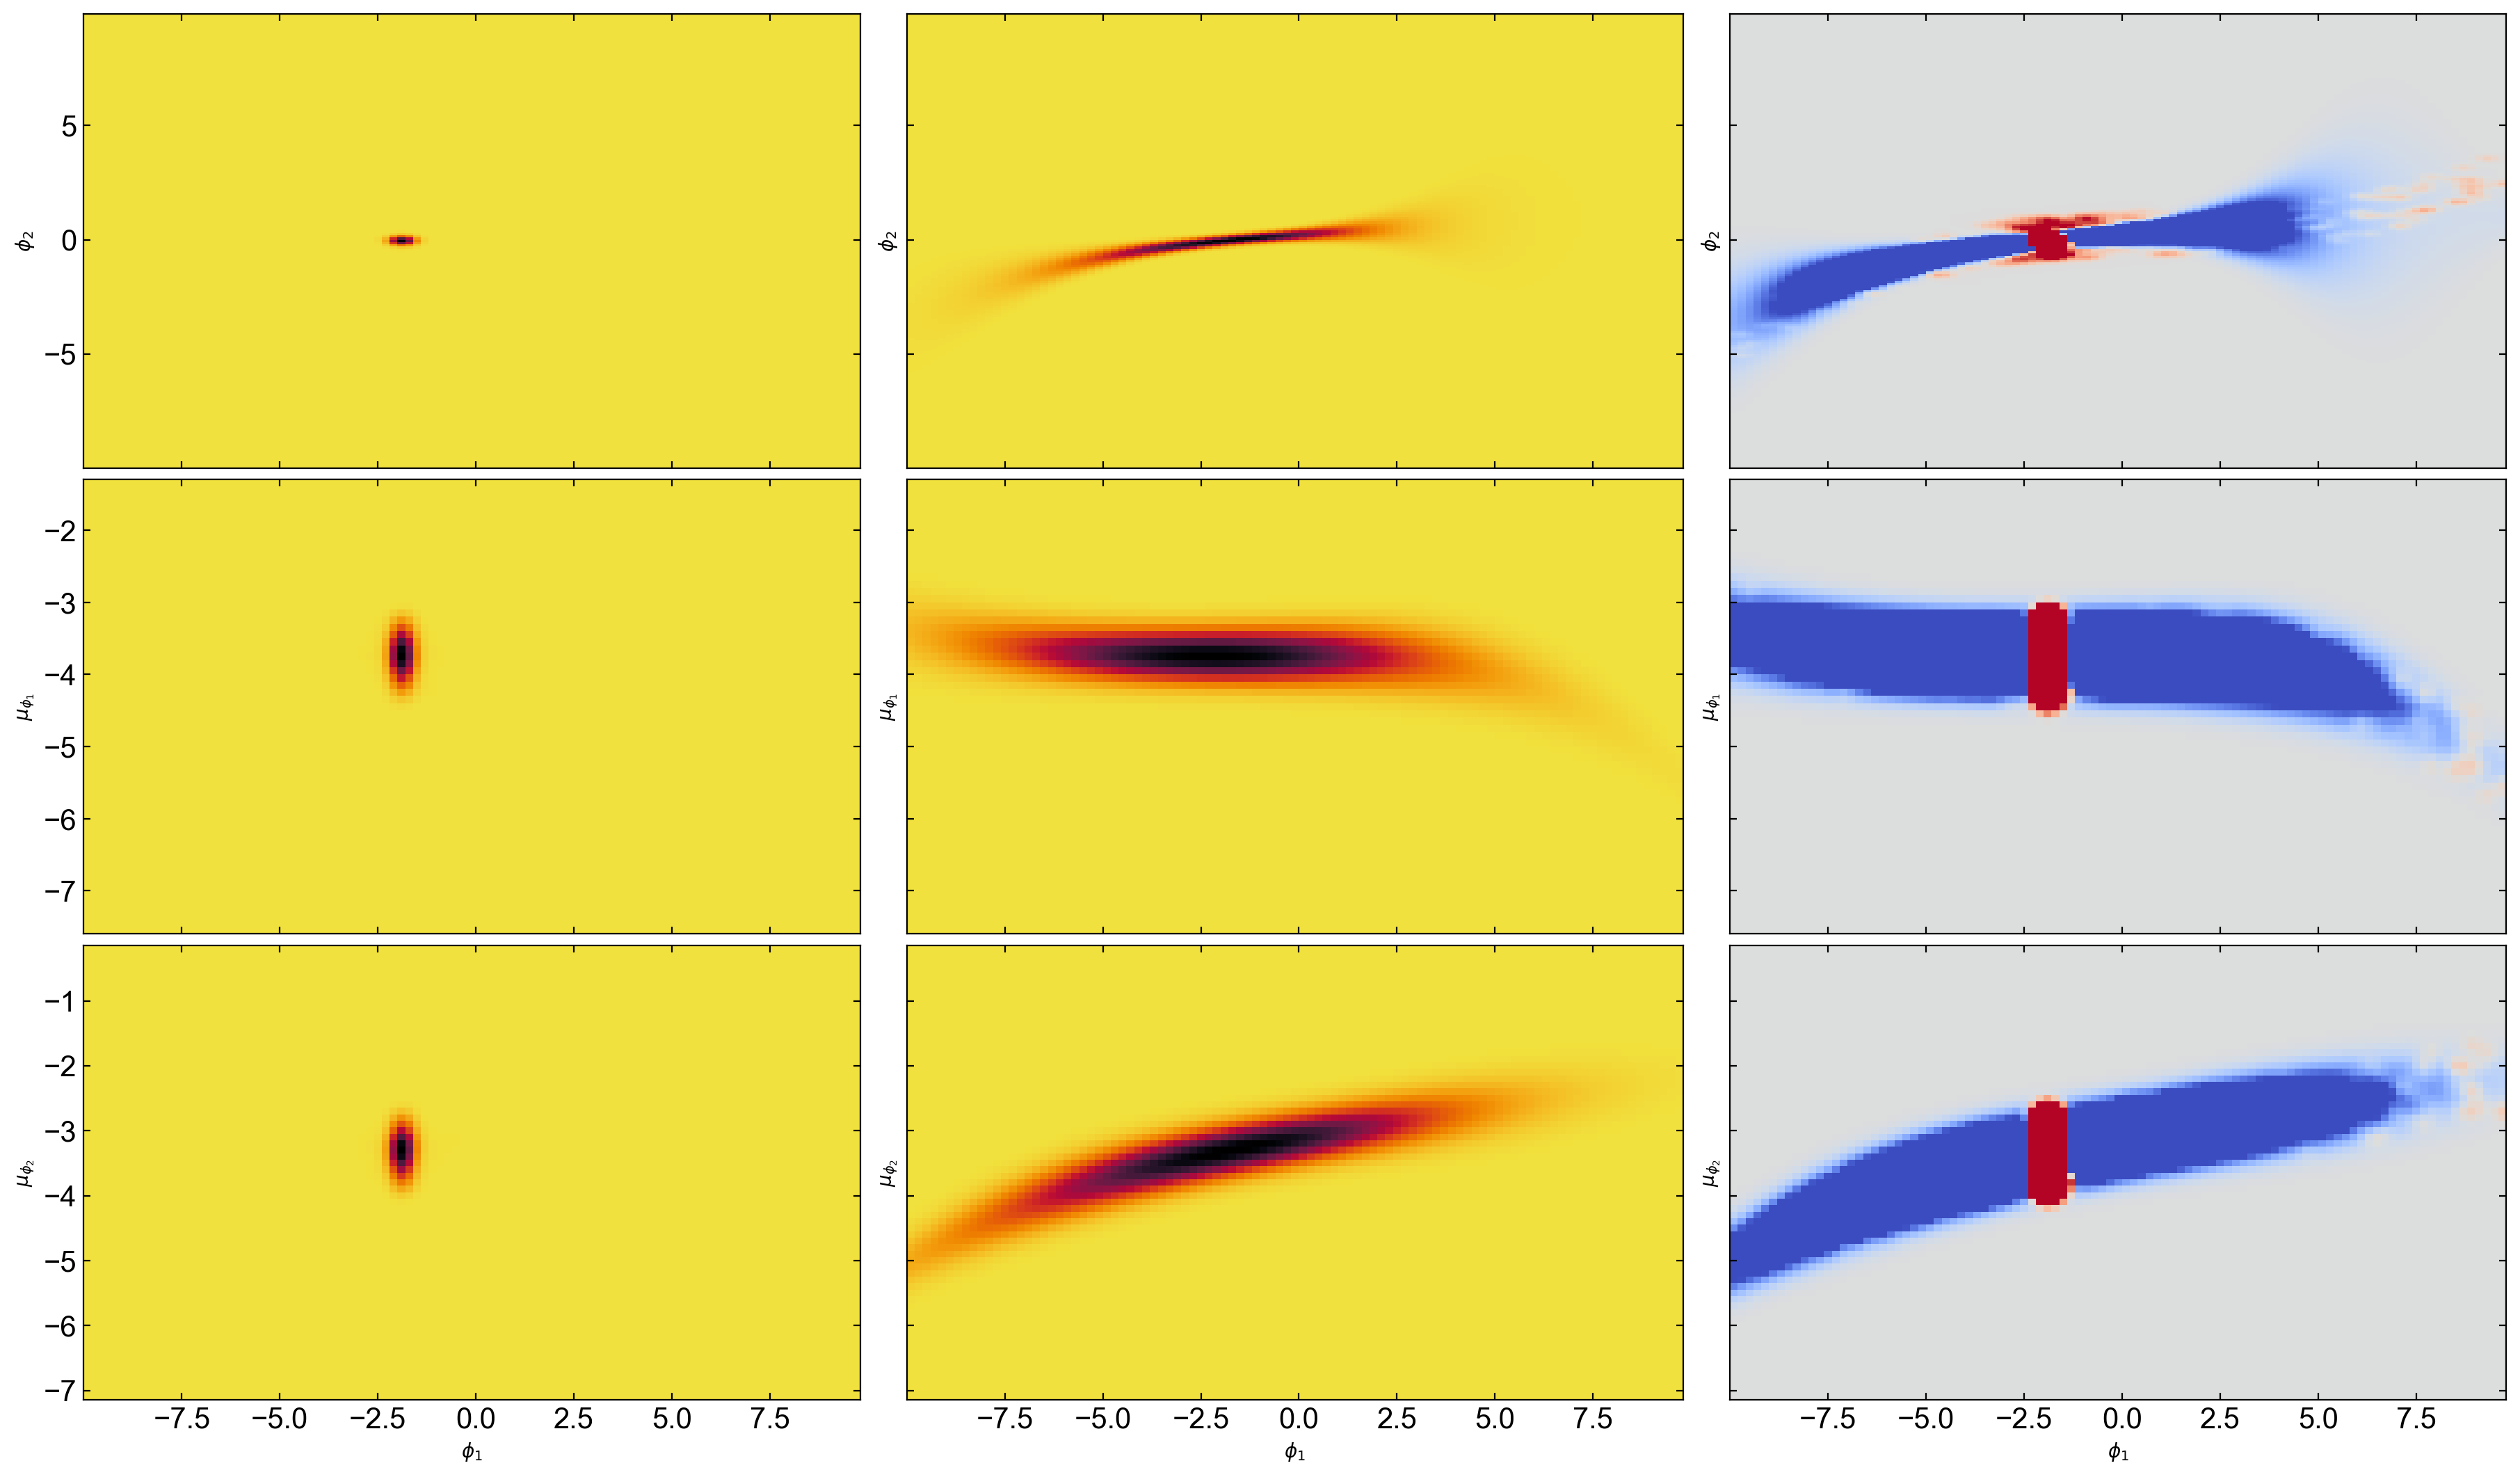

In [41]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

The problem with this is that the background model is not 2D so there is a lot of excess in certain parts that are being tracked as off-track features in this section.

In [42]:
Components = [StreamDensModel, BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}
mix_params0['background']['ln_N'] = np.log(len(run_data['phi1']) - np.exp(mix_params0['stream']['ln_N']))

In [43]:
mix_init = StreamMixtureModel(mix_params0, Components)

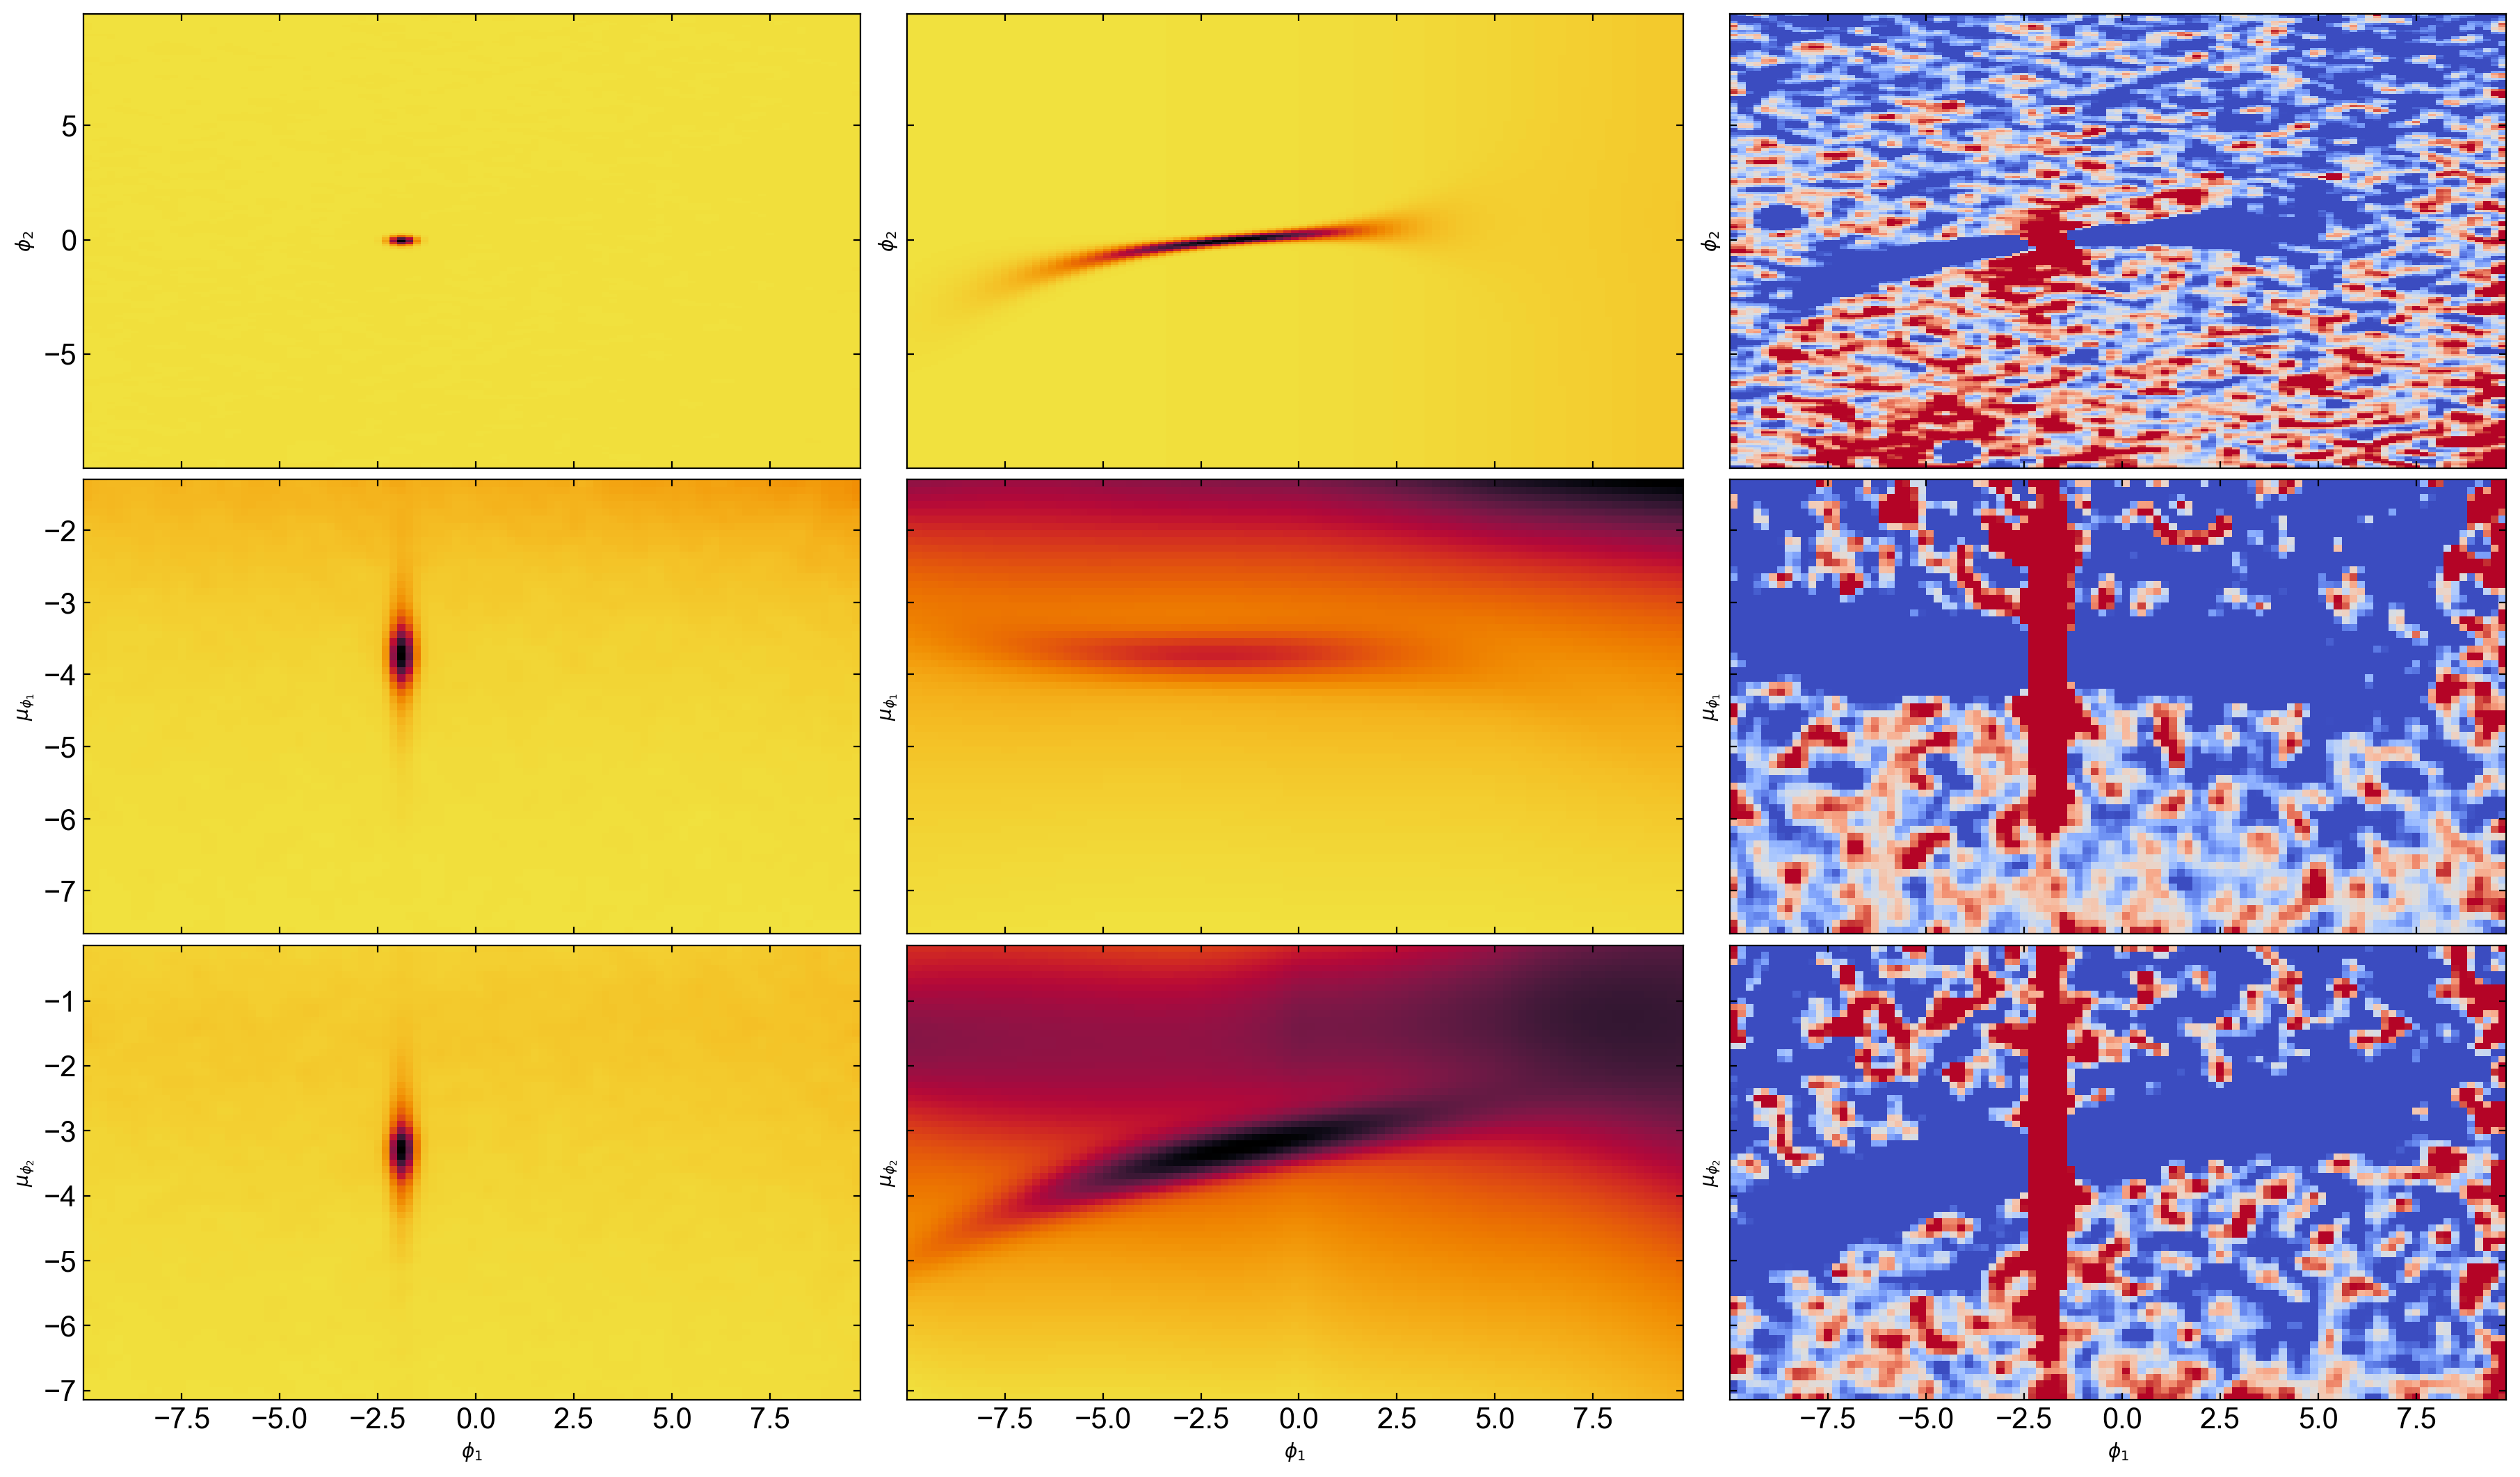

In [44]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [45]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=False
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(-1.62681649, dtype=float64, weak_type=True), success=True, status=0, iter_num=511, hess_inv=Array([[ 9.80898565e-01,  1.33846591e+00, -5.82684180e-01, ...,
         1.22963141e-01, -1.41232419e+00, -2.17804873e+00],
       [ 1.33846591e+00,  3.57888927e+02,  2.08107181e+02, ...,
        -8.86253113e+00, -3.12016045e+02, -4.69777721e+02],
       [-5.82684180e-01,  2.08107181e+02,  9.58917745e+02, ...,
         5.25802513e+00, -2.39956376e+01, -4.03864564e+02],
       ...,
       [ 1.22963141e-01, -8.86253113e+00,  5.25802513e+00, ...,
         1.94750624e+02,  1.32952486e+02, -3.10017920e+01],
       [-1.41232419e+00, -3.12016045e+02, -2.39956376e+01, ...,
         1.32952486e+02,  1.27536989e+03,  5.53847121e+02],
       [-2.17804873e+00, -4.69777721e+02, -4.03864564e+02, ...,
        -3.10017920e+01,  5.53847121e+02,  1.28291758e+03]],      dtype=float64), num_fun_eval=Array(513, dtype=int32), num_jac_eval=Array(513, dtype=int32), num_hess_eval=Array(0,

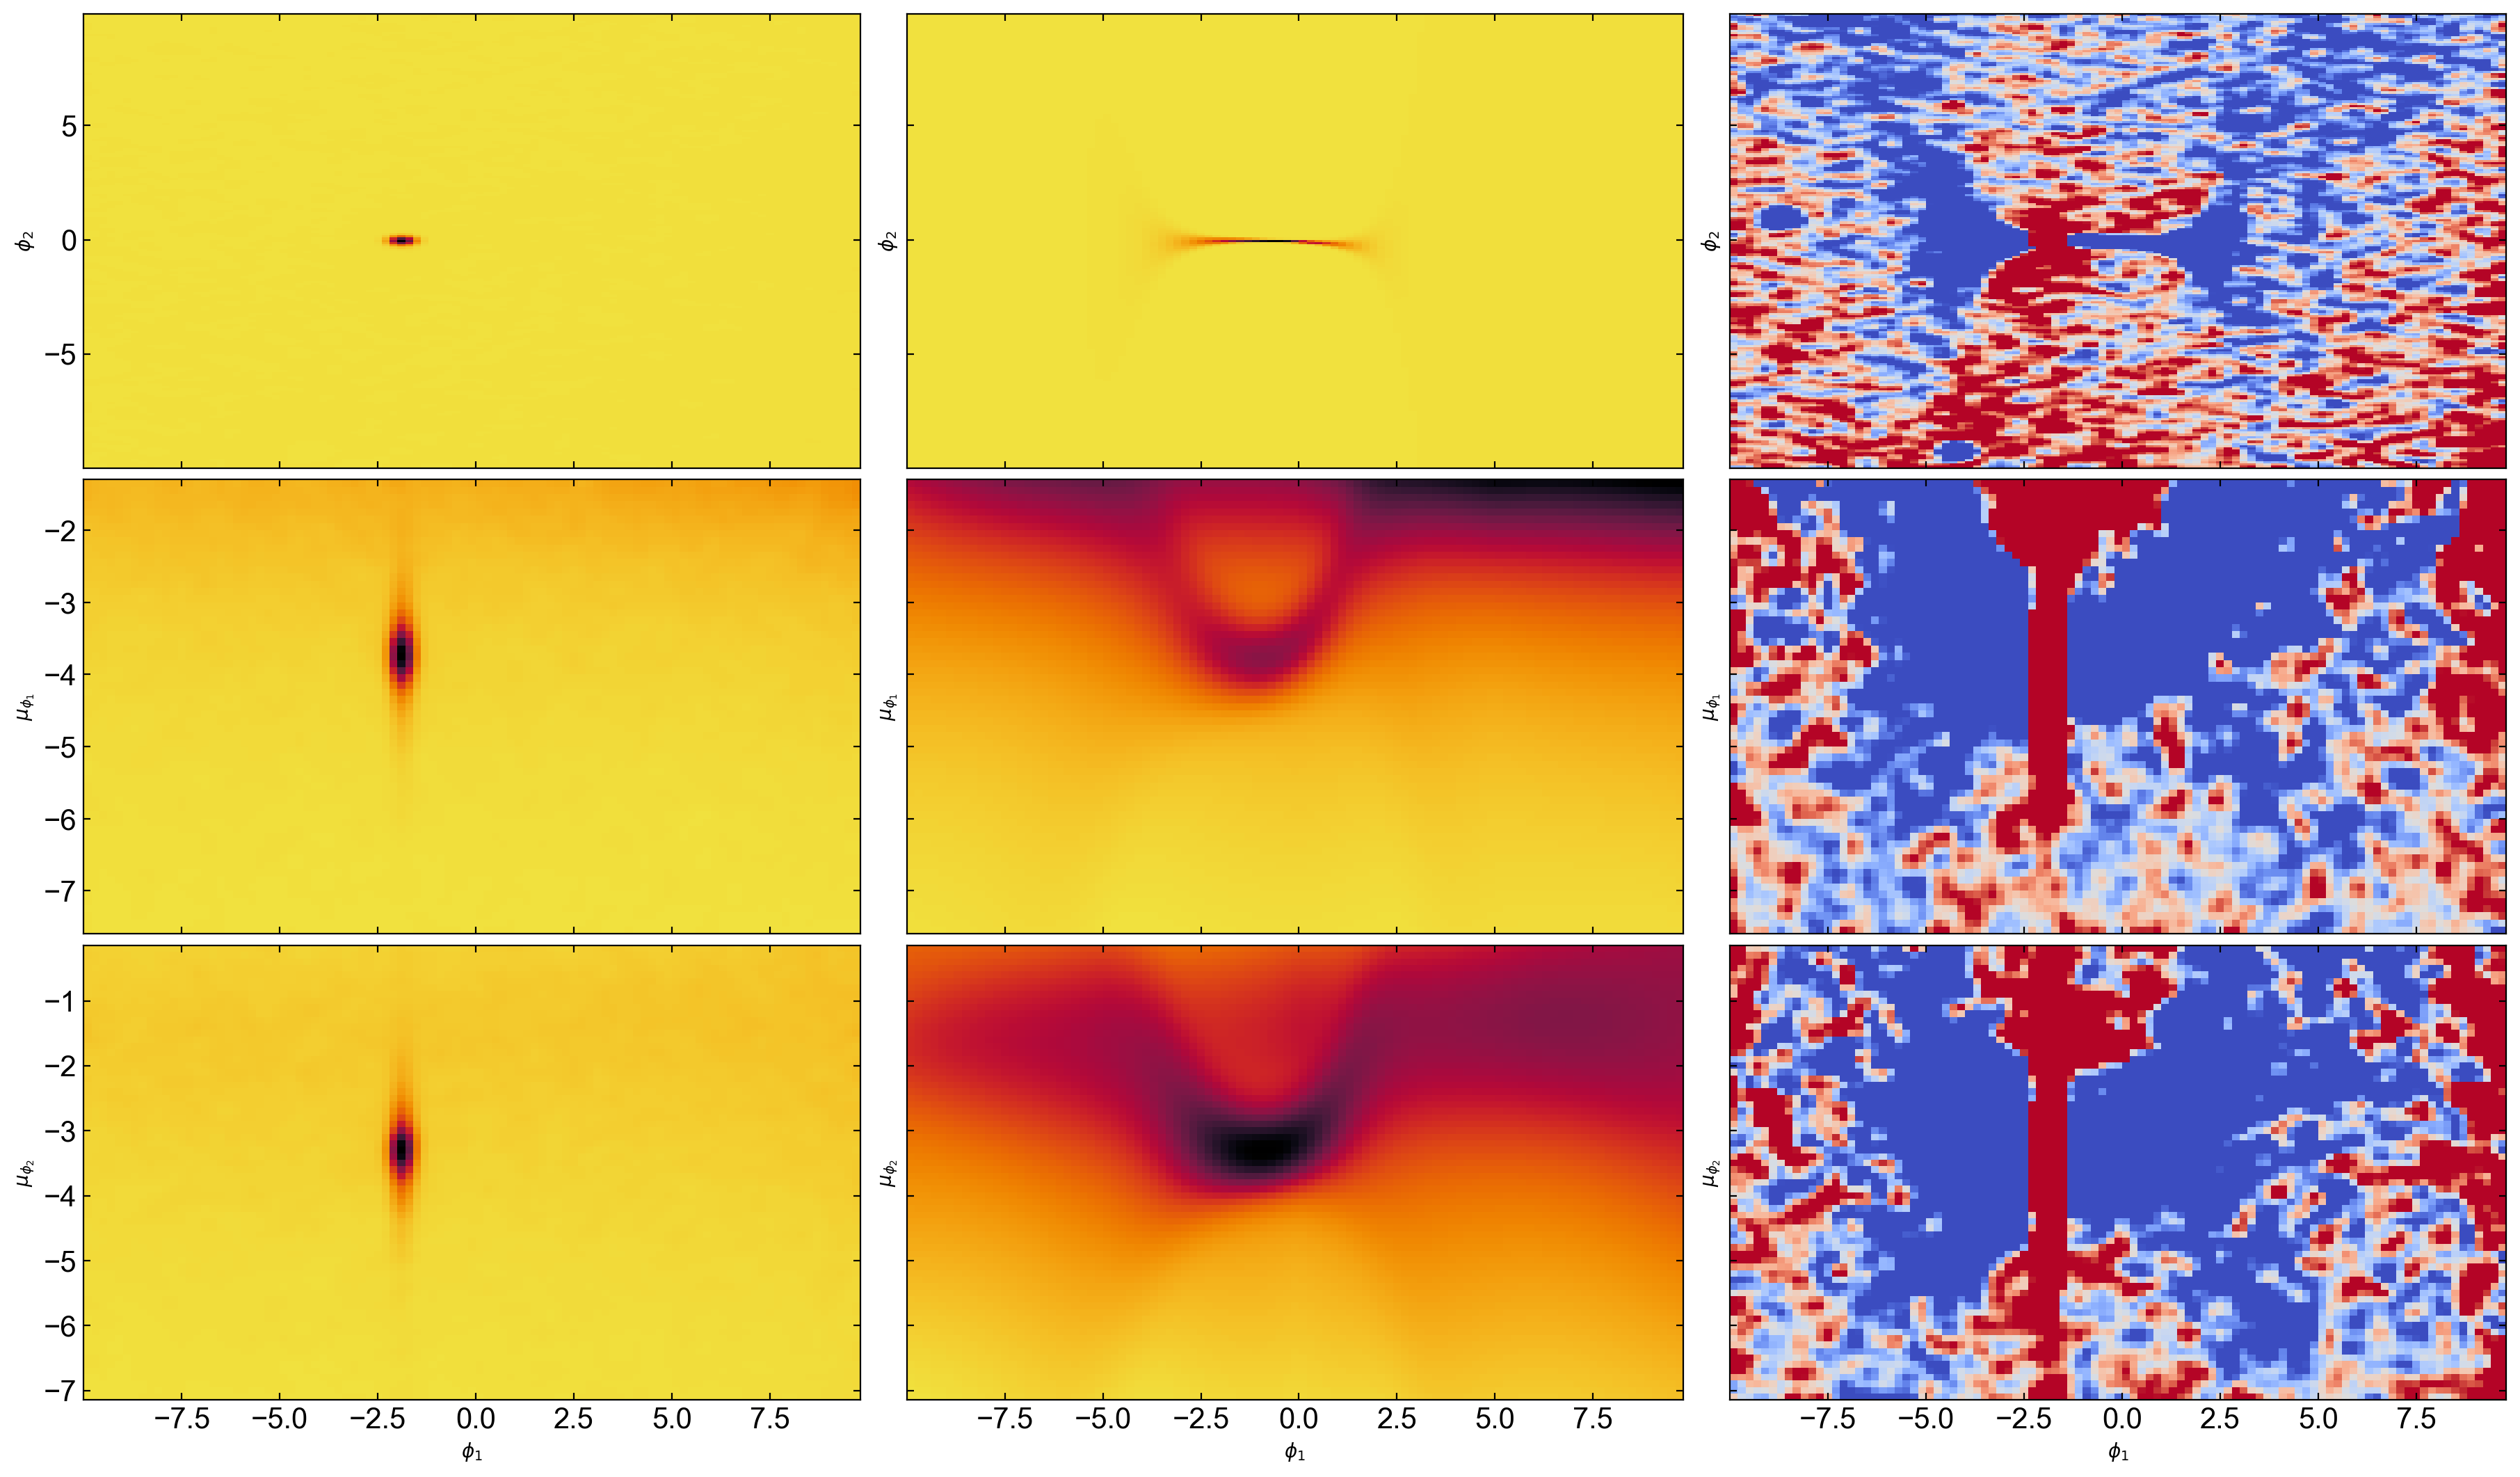

In [47]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [64]:
OffTrackModel.offtrack_update(p, cat, dens_steps=np.array([4,0.4]))

In [65]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

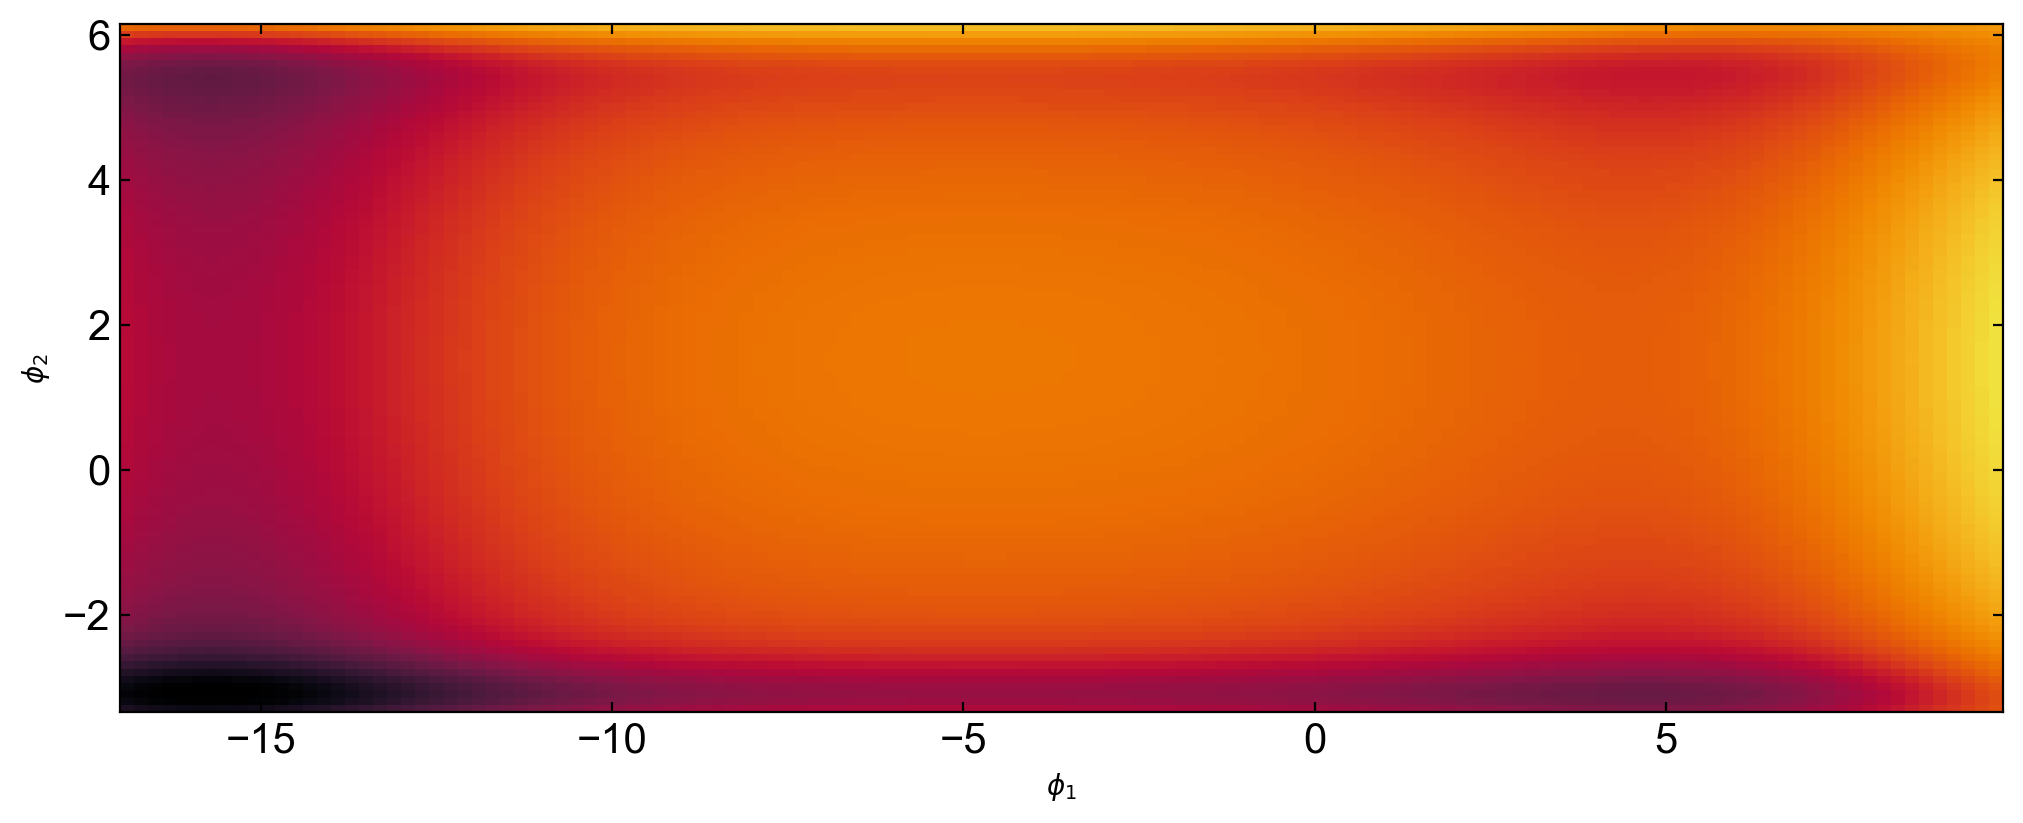

In [66]:
offtrack_model0 = OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [67]:
full_Components = [StreamDensModel, BackgroundModel, OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [68]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [69]:
full_mix_params0['offtrack'][('phi1', 'phi2')]['zs'].shape

(199,)

In [70]:
tied_params

[(('offtrack', 'pm1'), ('stream', 'pm1')),
 (('offtrack', 'pm2'), ('stream', 'pm2'))]

In [71]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

ScipyMinimizeInfo(fun_val=Array(-1.72625493, dtype=float64, weak_type=True), success=True, status=0, iter_num=201, hess_inv=LbfgsInvHessProduct(sk=[[-7.76989787e-04 -3.45381305e-03  2.18987104e-05 ...  5.11263149e-03
   1.81409957e-03 -1.15811050e-03]
 [-2.14400447e-03 -7.06387496e-03  4.06628694e-05 ...  1.10381723e-02
   2.08511399e-03 -1.88716859e-03]
 [-1.53734142e-02 -3.80226046e-03  1.63695188e-05 ... -1.90859023e-03
   5.45109723e-03 -1.87306744e-03]
 ...
 [-7.35305718e-03 -1.86628731e-03  1.16510215e-05 ... -1.96401924e-03
   2.00212146e-03 -7.62943250e-04]
 [-7.37946893e-03 -2.76509165e-03  1.74081585e-05 ... -1.85319698e-04
   2.50179405e-03 -1.07641339e-03]
 [-3.47786119e-03 -2.73295984e-03  1.75824701e-05 ...  2.40463998e-03
   1.95370996e-03 -1.00513106e-03]], yk=[[-5.25681874e-04  6.66945716e-05  4.96852047e-08 ...  3.54220507e-05
   2.14910524e-07  1.83283576e-07]
 [-1.04651056e-03  2.04741406e-05 -2.20263025e-08 ...  9.52692517e-05
  -8.57793776e-06  1.24601010e-06]
 [-

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

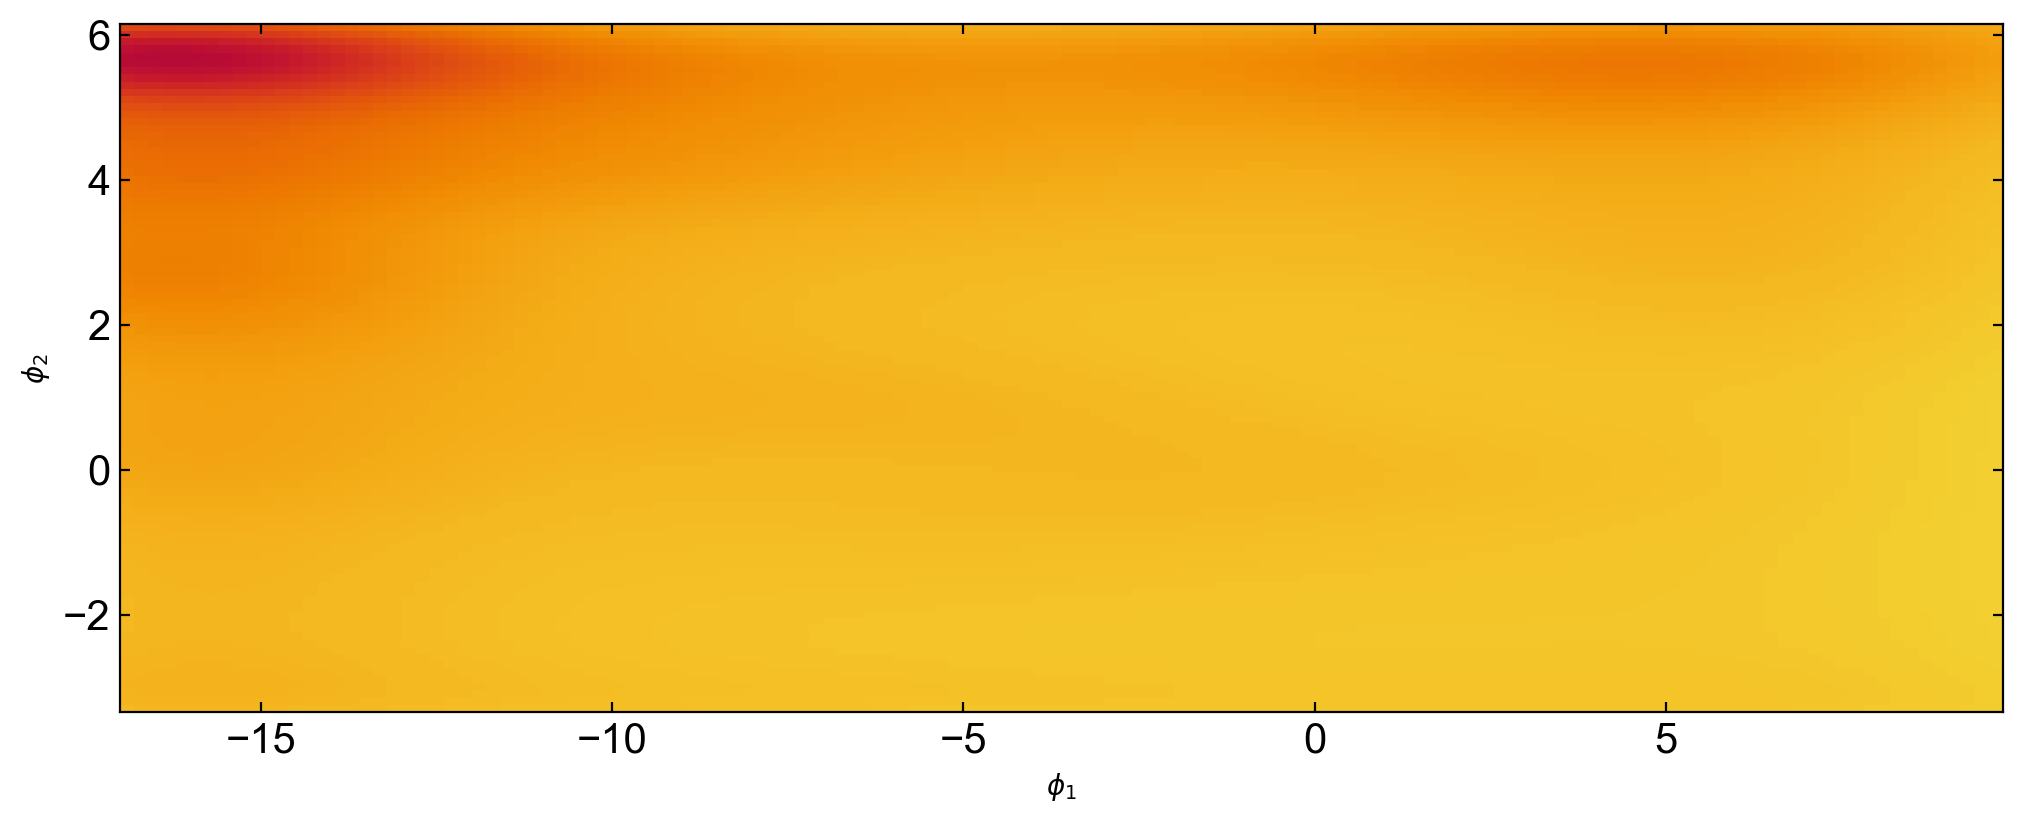

In [74]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=10, cmap='cmr.ember_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

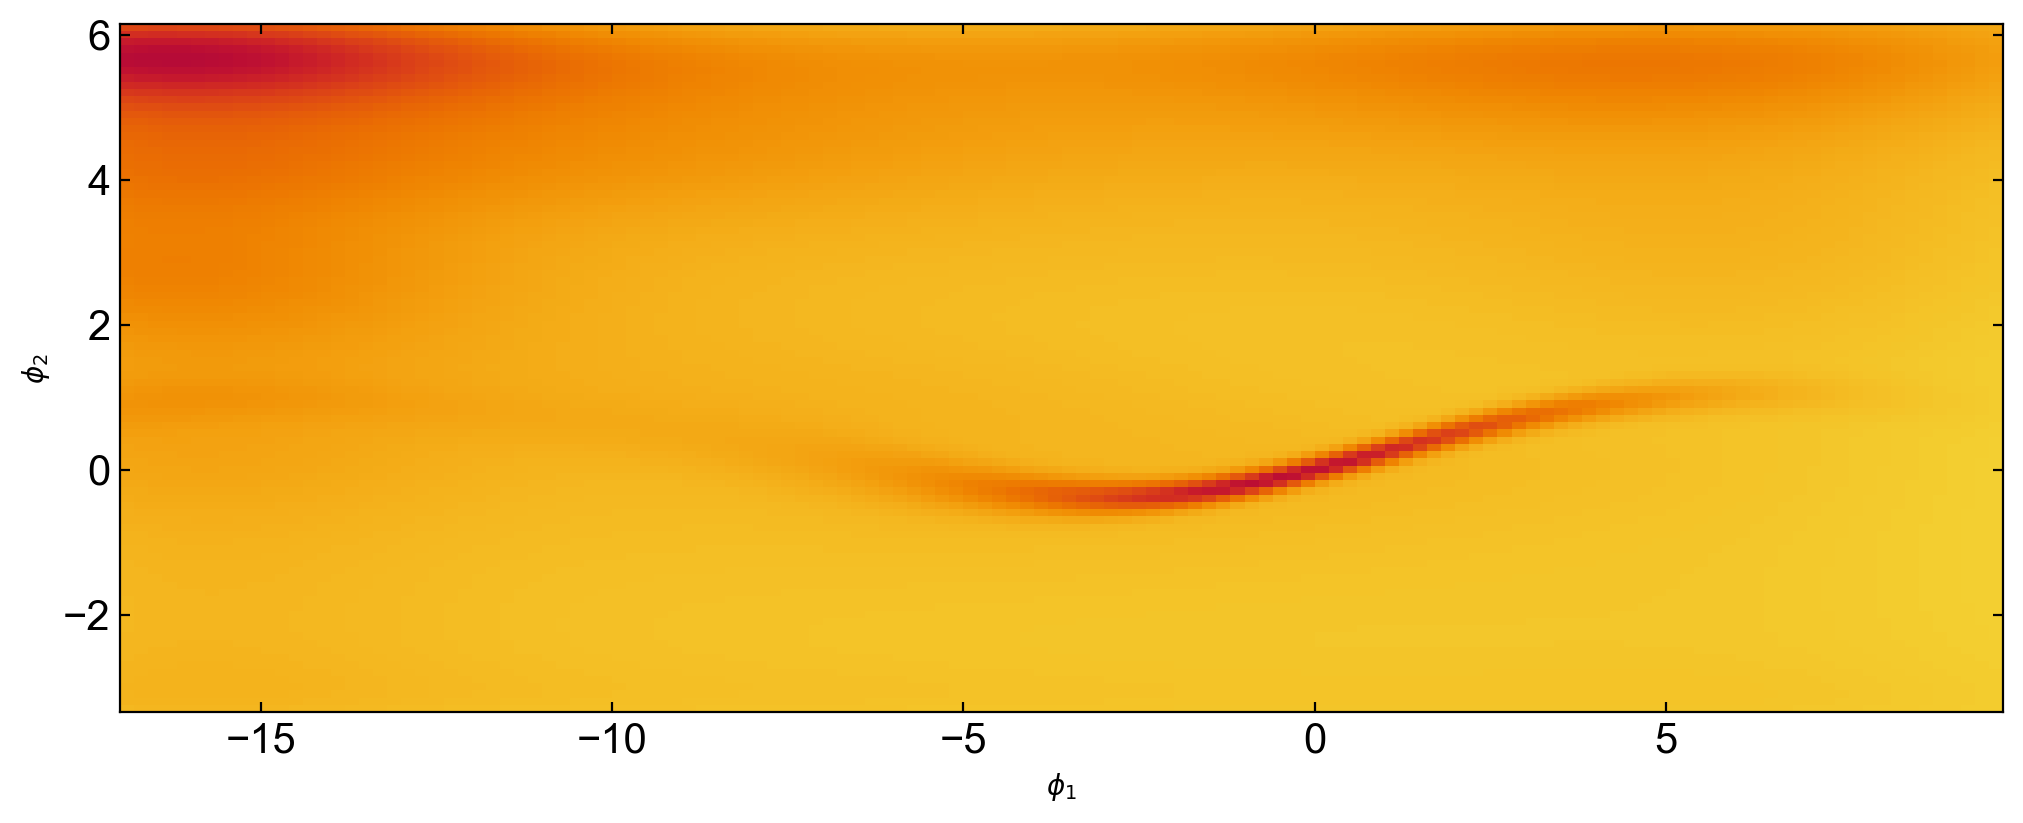

In [76]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=10, cmap='cmr.ember_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

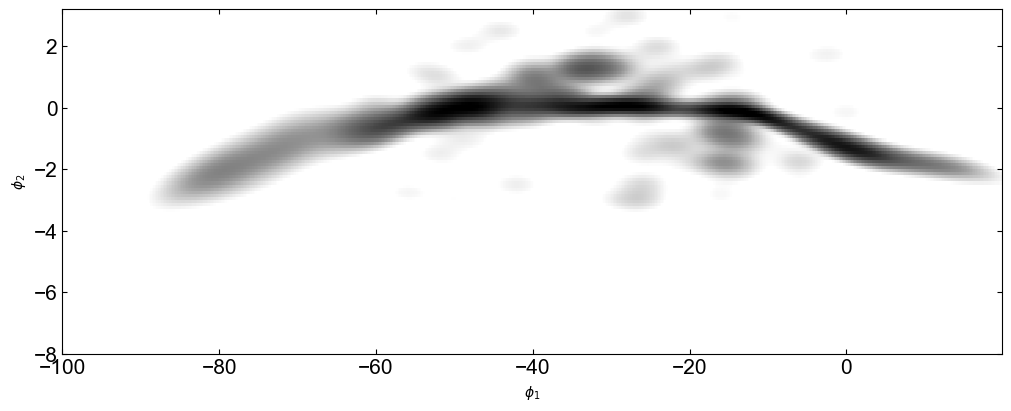

In [77]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [77]:
stream_comp, bkg_comp, offtrack_comp = full_mix_opt.components[0], full_mix_opt.components[1], full_mix_opt.components[2]
stream_ll = -np.log(stream_comp.get_N()) + stream_comp.ln_number_density(run_data)
bkg_ll = -np.log(bkg_comp.get_N()) + bkg_comp.ln_number_density(run_data)
offtrack_ll = -np.log(offtrack_comp.get_N()) + offtrack_comp.ln_number_density(run_data)

#one way
fg_ll = np.logaddexp(stream_ll, offtrack_ll)

#another way
# fg_comps = full_mix_nobkg_opt.components
# fg_ll_ = -np.log(fg_comps[0].get_N() + fg_comps[1].get_N()) + full_mix_nobkg_opt.ln_number_density(run_data)

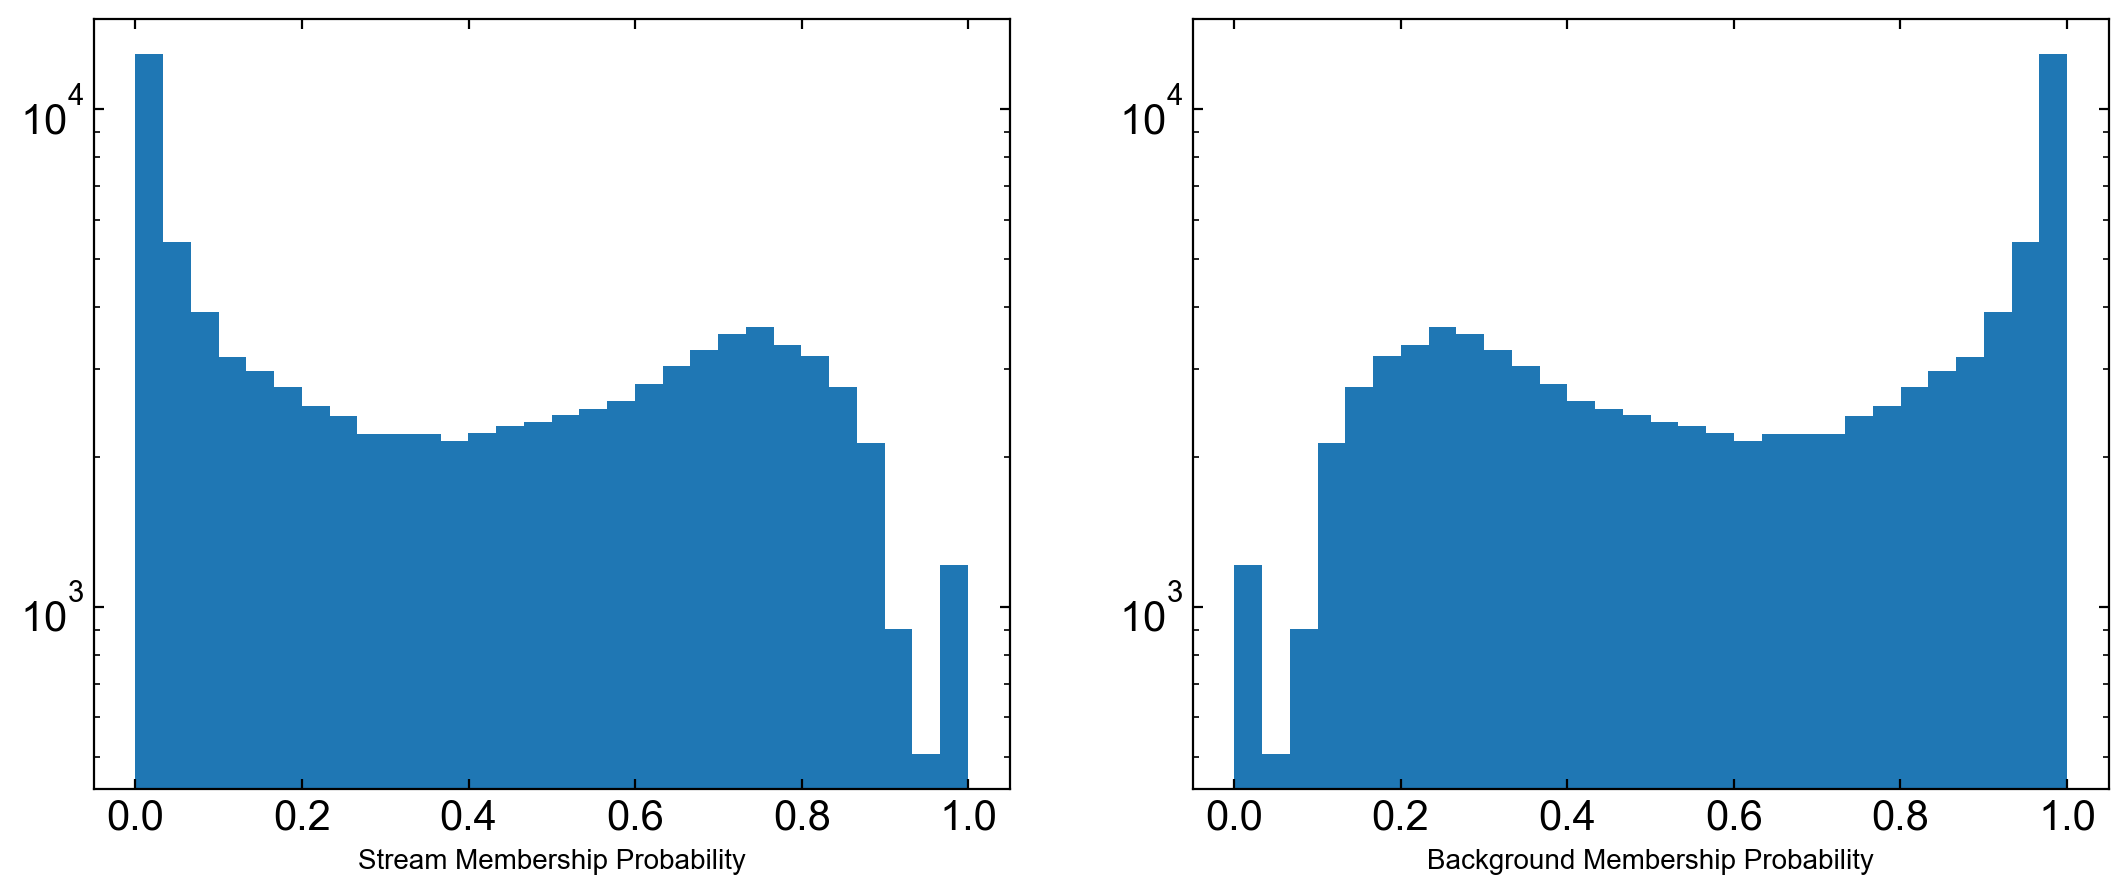

In [78]:
final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob, bins=30)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability')

ax2.hist(bkg_prob, bins=30)
ax2.set_xlabel('Background Membership Probability')
ax2.set_yscale('log')
plt.show()

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

Text(0, 0.5, '$\\phi_2$')

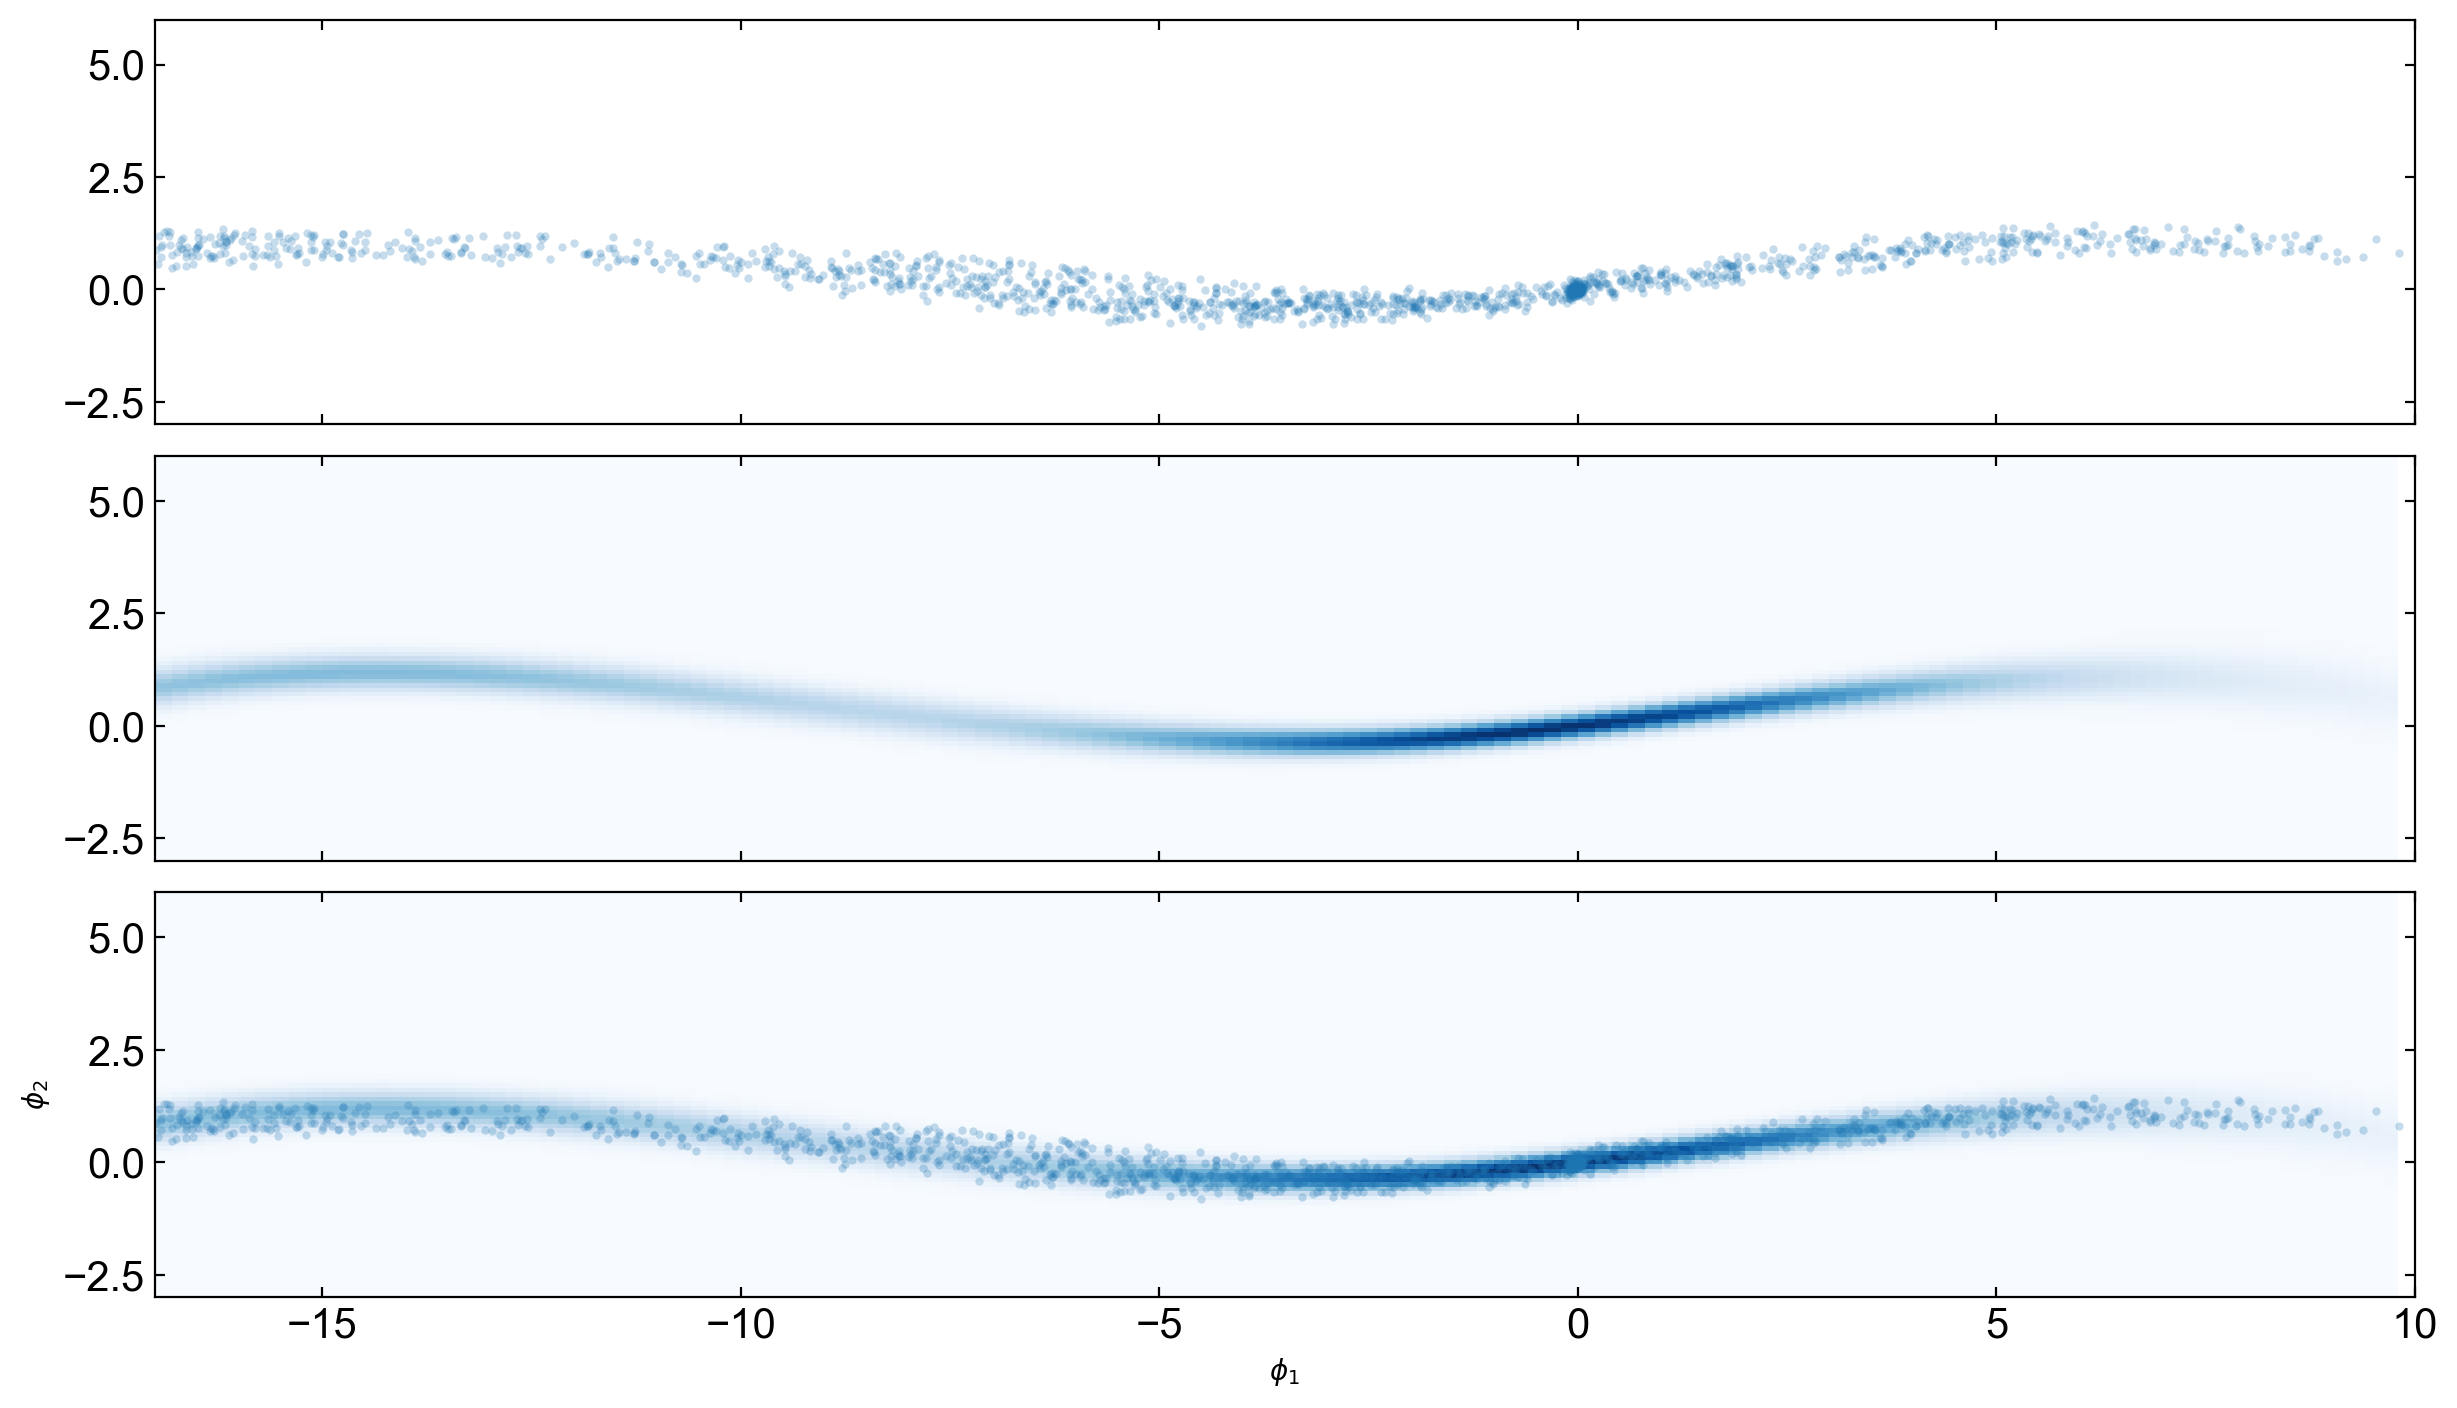

In [86]:
threshold = (final_memb_prob>0.95)

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][threshold],
        run_data['phi2'][threshold],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-17, 10)
ax.set_ylim(-3, 6)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")